# Fruit360 Report EDA and Results

This notebook generates report-ready figures and tables and saves them to `V2/report_assets/figures` and `MLProg/V2/report_assets/tables`.

In [2]:
import os
import random
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

ROOT_DIR = "dataset/fruit360"
TRAIN_DIR = os.path.join(ROOT_DIR, "Training")
TEST_DIR = os.path.join(ROOT_DIR, "Test")

OUTPUT_DIR = "report_assets"
FIG_DIR = os.path.join(OUTPUT_DIR, "figures")
TABLE_DIR = os.path.join(OUTPUT_DIR, "tables")

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)

def save_fig(name):
    path = os.path.join(FIG_DIR, name)
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print("Saved", path)


def save_table(df, name):
    csv_path = os.path.join(TABLE_DIR, name + ".csv")
    md_path = os.path.join(TABLE_DIR, name + ".md")
    df.to_csv(csv_path, index=False)
    try:
        df.to_markdown(md_path, index=False)
    except Exception:
        df.to_csv(md_path, index=False)
    print("Saved", csv_path)
    print("Saved", md_path)

## 1. Dataset EDA

Training: 130344 images, 79 classes
Test: 43442 images, 79 classes
Train 91240, Val 39104, Test 43442
Saved report_assets/figures/fig_01_train_class_distribution.png


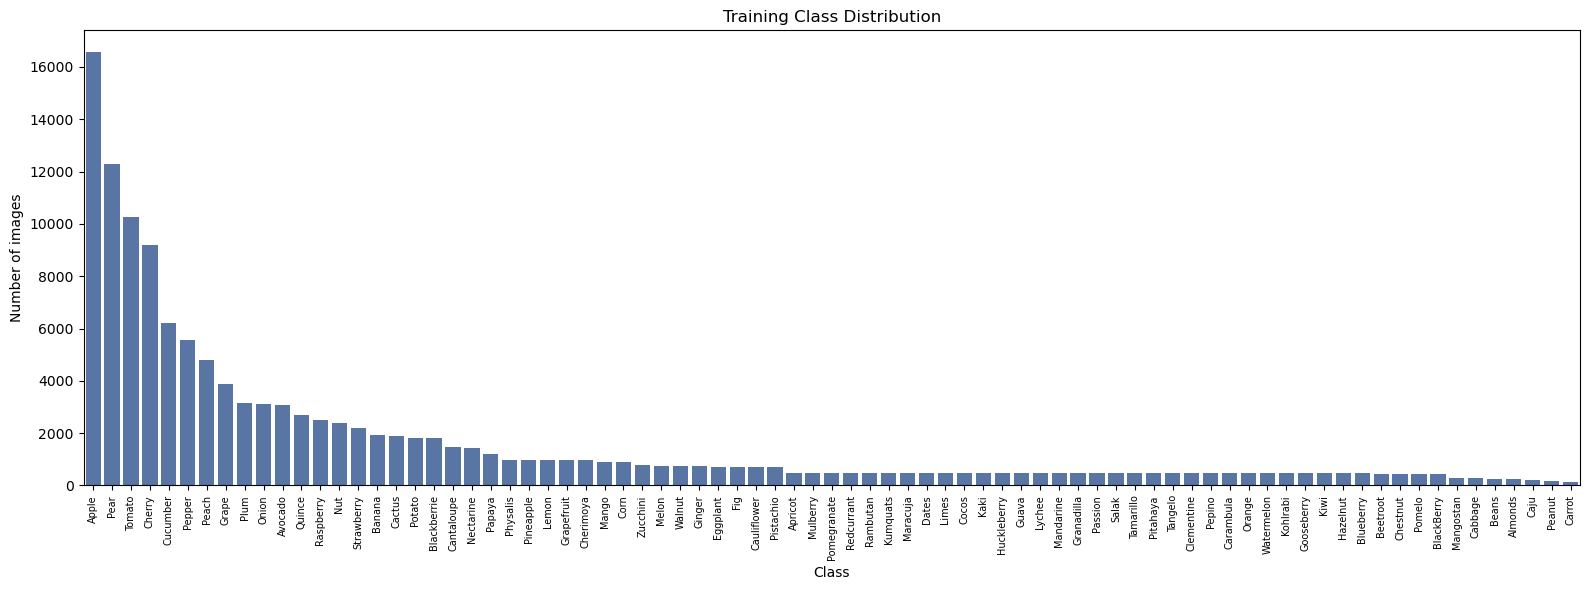

Saved report_assets/figures/fig_02_class_counts_splits.png


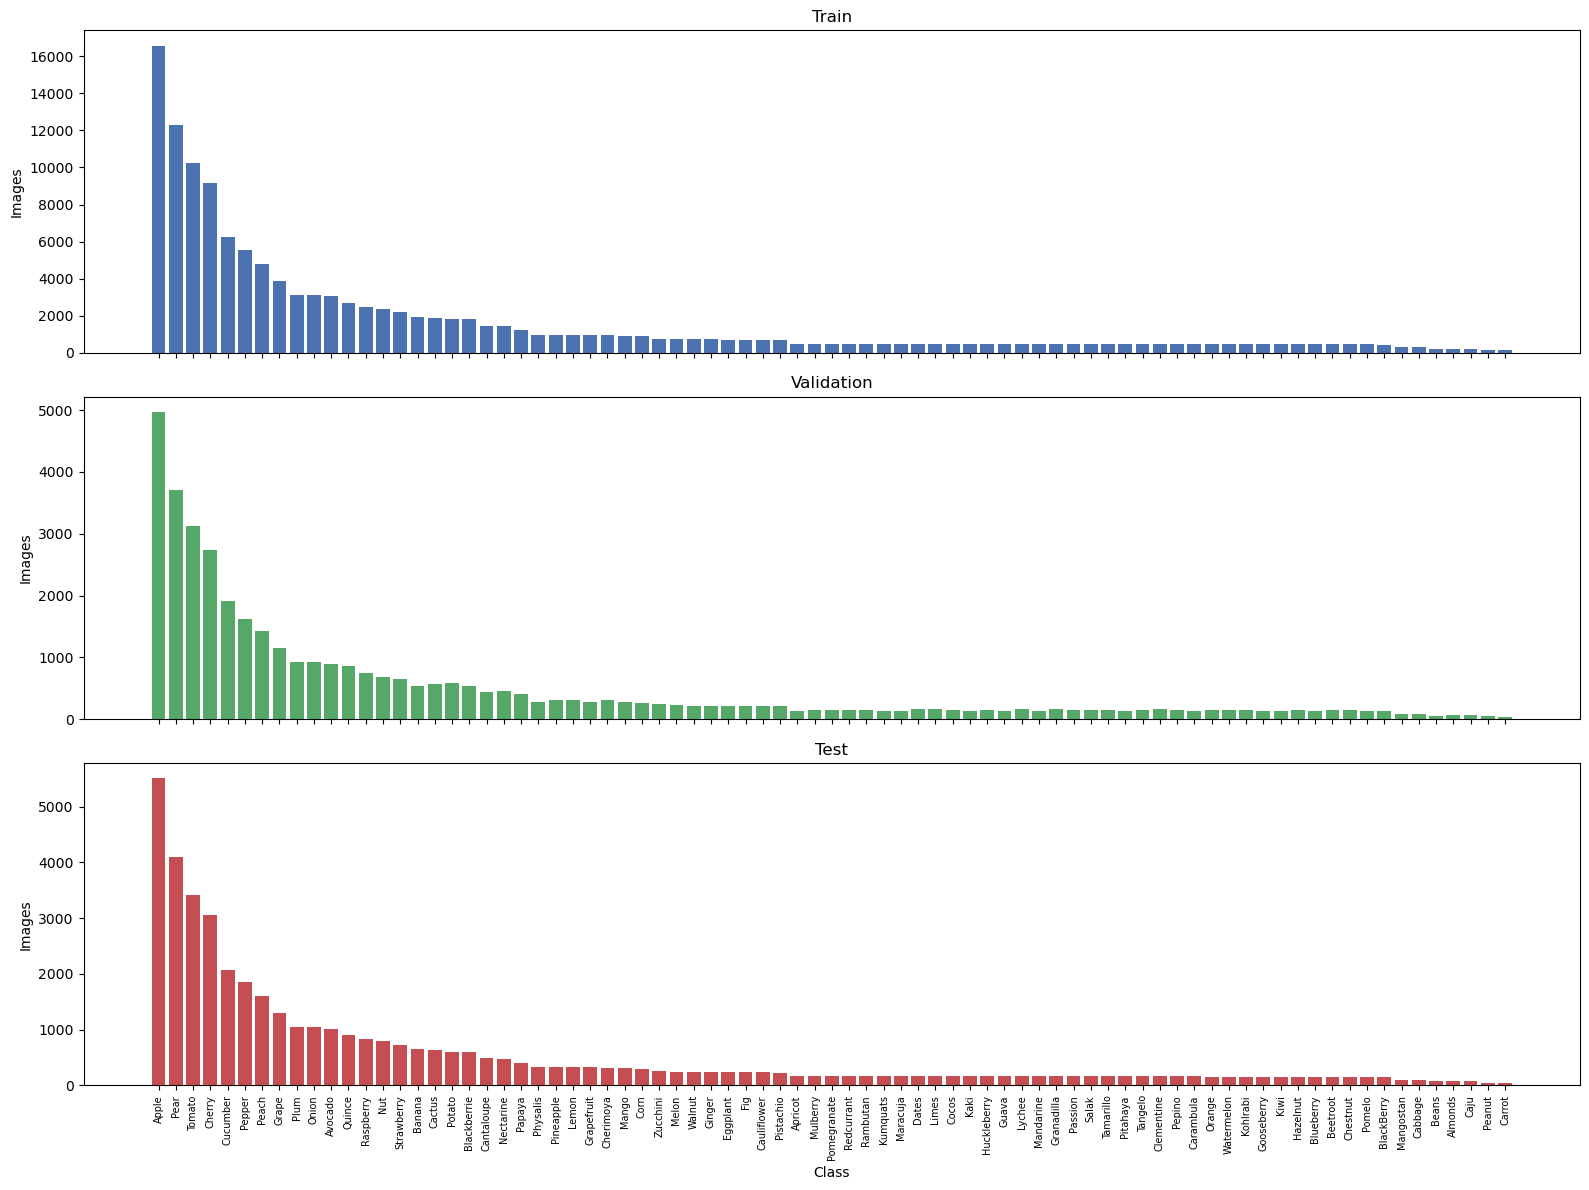

Saved report_assets/tables/table_01_split_summary.csv
Saved report_assets/tables/table_01_split_summary.md


,Split,Number of images,Number of classes
0,Train,91240,79
1,Validation,39104,79
2,Test,43442,79


In [3]:
class Fruit360FolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, variety=False):
        self.root_dir = root_dir
        self.transform = transform
        self.variety = variety
        self.samples = []

        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            label = class_name if self.variety else class_name.split()[0]
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith((".jpg", ".png")):
                    self.samples.append((os.path.join(class_dir, img_name), label))

        unique_labels = sorted({lbl for _, lbl in self.samples})
        self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        self.idx_to_label = {i: lbl for i, lbl in self.label_to_idx.items()}

        print(f"{os.path.basename(root_dir)}: {len(self.samples)} images, {len(unique_labels)} classes")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_str = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label_str


def get_labels_from_dataset(ds):
    if hasattr(ds, "samples"):
        return [lbl for _, lbl in ds.samples]
    if hasattr(ds, "dataset") and hasattr(ds.dataset, "samples"):
        return [ds.dataset.samples[i][1] for i in ds.indices]
    return []


def count_labels(ds):
    labels = get_labels_from_dataset(ds)
    return pd.Series(labels).value_counts()


train_full = Fruit360FolderDataset(TRAIN_DIR, transform=None, variety=False)
test_dataset = Fruit360FolderDataset(TEST_DIR, transform=None, variety=False)

train_size = int(0.7 * len(train_full))
val_size = len(train_full) - train_size

train_dataset, val_dataset = random_split(
    train_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(RANDOM_STATE),
)

print(f"Train {len(train_dataset)}, Val {len(val_dataset)}, Test {len(test_dataset)}")

train_counts = count_labels(train_full).sort_values(ascending=False)
val_counts = count_labels(val_dataset).reindex(train_counts.index).fillna(0).astype(int)
test_counts = count_labels(test_dataset).reindex(train_counts.index).fillna(0).astype(int)

plt.figure(figsize=(16, 6))
sns.barplot(x=train_counts.index, y=train_counts.values, color="#4C72B0")
plt.xticks(rotation=90, fontsize=7)
plt.title("Training Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.tight_layout()
save_fig("fig_01_train_class_distribution.png")
plt.show()

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
axes[0].bar(train_counts.index, train_counts.values, color="#4C72B0")
axes[0].set_title("Train")
axes[1].bar(train_counts.index, val_counts.values, color="#55A868")
axes[1].set_title("Validation")
axes[2].bar(train_counts.index, test_counts.values, color="#C44E52")
axes[2].set_title("Test")
axes[2].set_xlabel("Class")
for ax in axes:
    ax.tick_params(axis="x", labelrotation=90, labelsize=7)
    ax.set_ylabel("Images")
plt.tight_layout()
save_fig("fig_02_class_counts_splits.png")
plt.show()

split_summary = pd.DataFrame([
    {"Split": "Train", "Number of images": len(train_dataset), "Number of classes": len(train_full.label_to_idx)},
    {"Split": "Validation", "Number of images": len(val_dataset), "Number of classes": len(train_full.label_to_idx)},
    {"Split": "Test", "Number of images": len(test_dataset), "Number of classes": len(test_dataset.label_to_idx)},
])

save_table(split_summary, "table_01_split_summary")
split_summary

### 1.2 Example images

Saved report_assets/figures/fig_03_example_images_grid.png


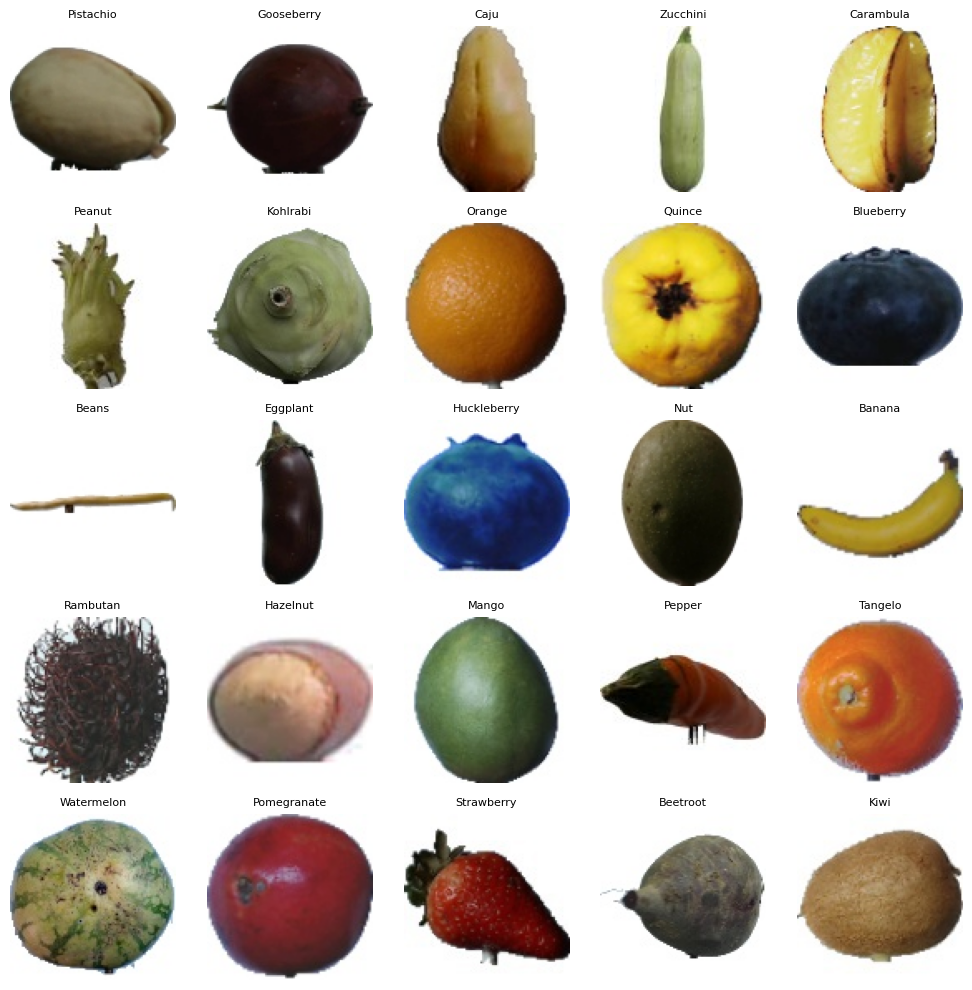

Saved report_assets/figures/fig_04_similar_classes_examples.png


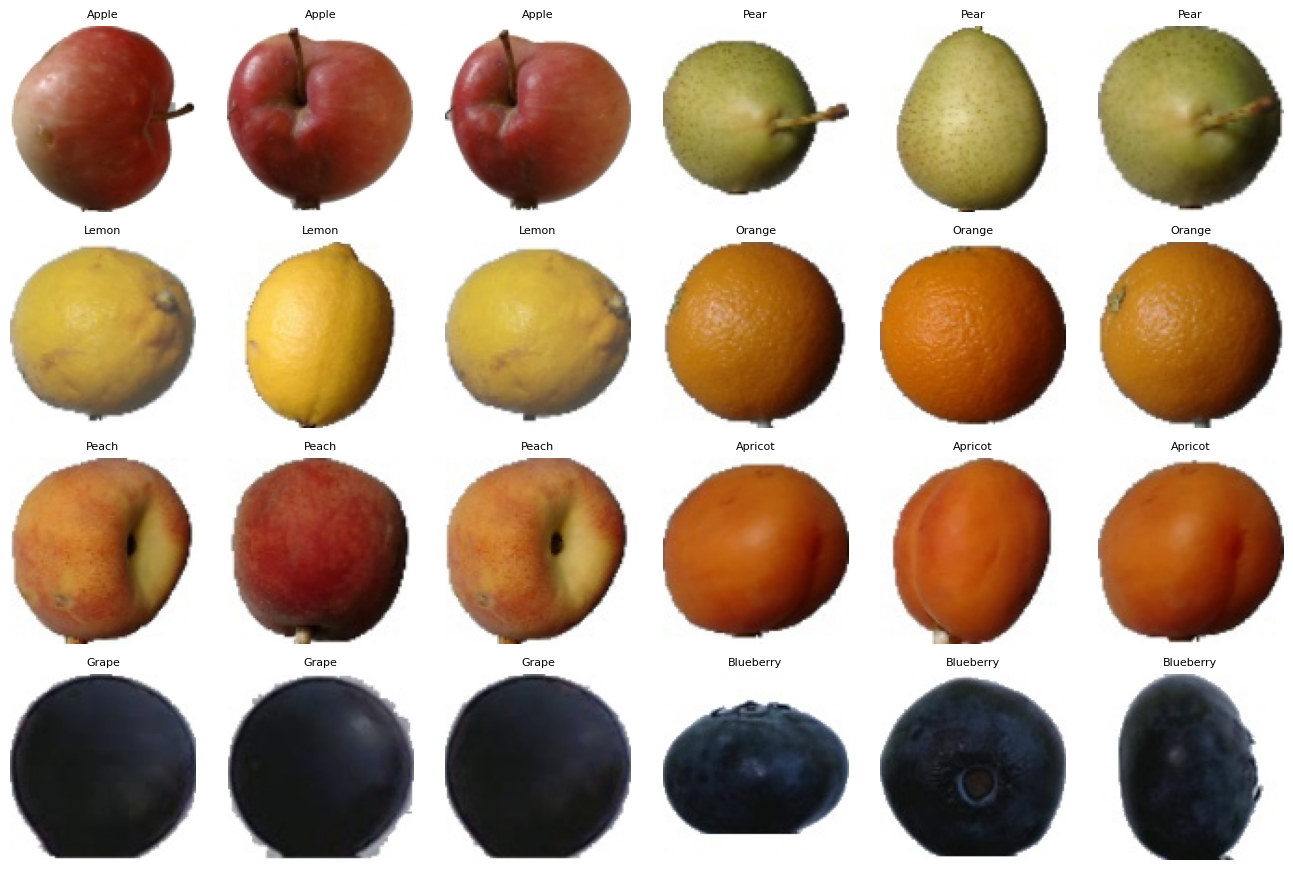

In [4]:
label_list = list(train_full.label_to_idx.keys())

rng = np.random.default_rng(RANDOM_STATE)
example_labels = rng.choice(label_list, size=25, replace=False)

example_paths = {}
for path, lbl in train_full.samples:
    if lbl in example_labels and lbl not in example_paths:
        example_paths[lbl] = path
    if len(example_paths) == len(example_labels):
        break

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for ax, lbl in zip(axes.flatten(), example_labels):
    img = Image.open(example_paths[lbl]).convert("RGB")
    ax.imshow(img)
    ax.set_title(lbl, fontsize=8)
    ax.axis("off")
for ax in axes.flatten()[len(example_labels):]:
    ax.axis("off")
plt.tight_layout()
save_fig("fig_03_example_images_grid.png")
plt.show()

SIMILAR_PAIRS = [
    ("Apple", "Pear"),
    ("Lemon", "Orange"),
    ("Peach", "Apricot"),
    ("Grape", "Blueberry"),
]

available = set(label_list)
valid_pairs = [(a, b) for a, b in SIMILAR_PAIRS if a in available and b in available]

if len(valid_pairs) == 0:
    valid_pairs = [(label_list[0], label_list[1])]

n_per_class = 3

rows = len(valid_pairs)
cols = n_per_class * 2
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
if rows == 1:
    axes = np.expand_dims(axes, axis=0)

for row_idx, (a, b) in enumerate(valid_pairs):
    a_paths = [p for p, lbl in train_full.samples if lbl == a][:n_per_class]
    b_paths = [p for p, lbl in train_full.samples if lbl == b][:n_per_class]
    for i in range(n_per_class):
        ax = axes[row_idx, i]
        img = Image.open(a_paths[i]).convert("RGB")
        ax.imshow(img)
        ax.set_title(a, fontsize=8)
        ax.axis("off")
    for i in range(n_per_class):
        ax = axes[row_idx, n_per_class + i]
        img = Image.open(b_paths[i]).convert("RGB")
        ax.imshow(img)
        ax.set_title(b, fontsize=8)
        ax.axis("off")

plt.tight_layout()
save_fig("fig_04_similar_classes_examples.png")
plt.show()

### 1.3 Pixel and color statistics

Saved report_assets/figures/fig_05_luminance_histogram.png


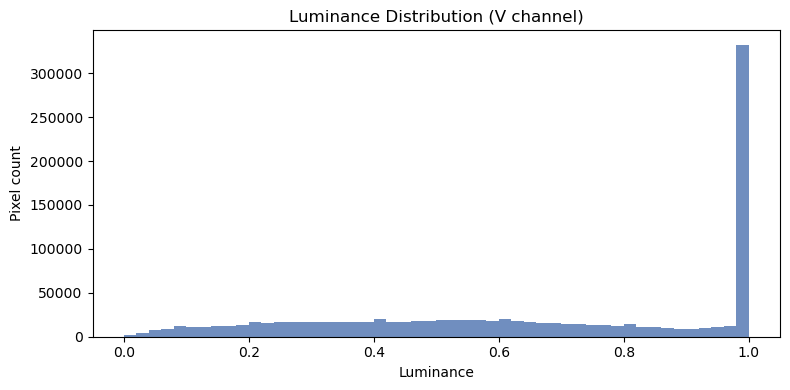

Saved report_assets/figures/fig_06_hue_distributions_by_class.png


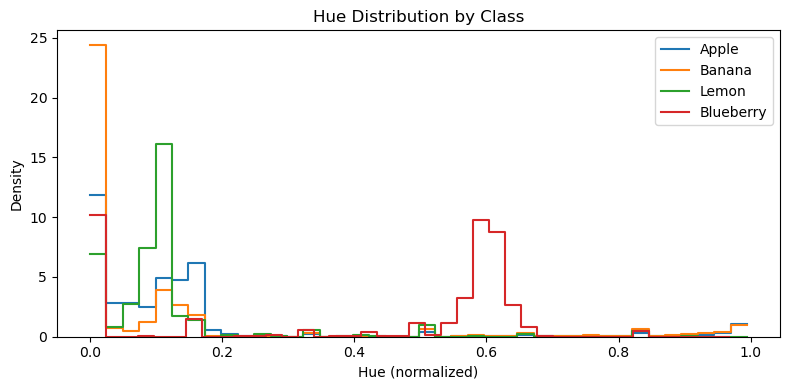

Saved report_assets/figures/fig_07_pca_pixels_2d_scatter.png


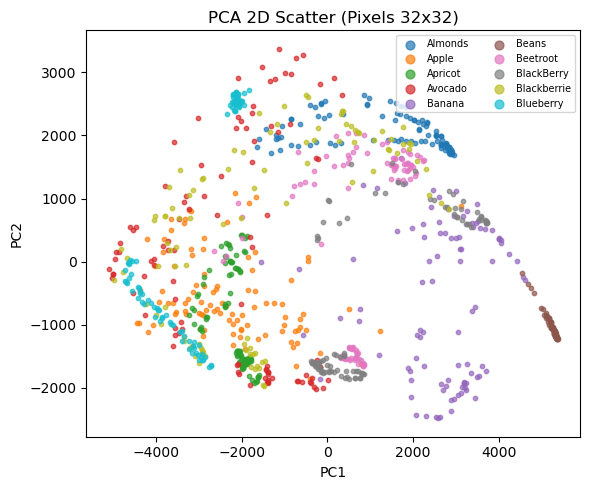

In [5]:
def load_image_array(path, size=None):
    img = Image.open(path).convert("RGB")
    if size is not None:
        img = img.resize((size, size))
    return np.array(img)

subset_paths = rng.choice([p for p, _ in train_full.samples], size=1000, replace=False)

luminance_vals = []
for path in subset_paths:
    img = load_image_array(path, size=32)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v = hsv[:, :, 2].astype(np.float32) / 255.0
    luminance_vals.append(v.ravel())

luminance_vals = np.concatenate(luminance_vals, axis=0)

plt.figure(figsize=(8, 4))
plt.hist(luminance_vals, bins=50, color="#4C72B0", alpha=0.8)
plt.title("Luminance Distribution (V channel)")
plt.xlabel("Luminance")
plt.ylabel("Pixel count")
plt.tight_layout()
save_fig("fig_05_luminance_histogram.png")
plt.show()

hue_classes = [c for c in ["Apple", "Banana", "Lemon", "Blueberry"] if c in label_list]
if len(hue_classes) == 0:
    hue_classes = label_list[:4]

hue_data = {}
for cls in hue_classes:
    paths = [p for p, lbl in train_full.samples if lbl == cls]
    paths = rng.choice(paths, size=min(200, len(paths)), replace=False)
    h_vals = []
    for path in paths:
        img = load_image_array(path, size=32)
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h = hsv[:, :, 0].astype(np.float32) / 180.0
        h_vals.append(h.ravel())
    hue_data[cls] = np.concatenate(h_vals, axis=0)

plt.figure(figsize=(8, 4))
for cls, vals in hue_data.items():
    sns.histplot(vals, bins=40, stat="density", label=cls, element="step", fill=False)
plt.title("Hue Distribution by Class")
plt.xlabel("Hue (normalized)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
save_fig("fig_06_hue_distributions_by_class.png")
plt.show()

pca_classes = label_list[:10]
per_class = 100
pca_paths = []
labels_pca = []
for cls in pca_classes:
    paths = [p for p, lbl in train_full.samples if lbl == cls]
    paths = rng.choice(paths, size=min(per_class, len(paths)), replace=False)
    pca_paths.extend(paths)
    labels_pca.extend([cls] * len(paths))

X_pixels = []
for path in pca_paths:
    img = load_image_array(path, size=32)
    X_pixels.append(img.reshape(-1))

X_pixels = np.stack(X_pixels, axis=0)

pca_2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca_2.fit_transform(X_pixels)

plt.figure(figsize=(6, 5))
for cls in pca_classes:
    idx = [i for i, c in enumerate(labels_pca) if c == cls]
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=10, alpha=0.7, label=cls)
plt.title("PCA 2D Scatter (Pixels 32x32)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(markerscale=2, fontsize=7, ncol=2)
plt.tight_layout()
save_fig("fig_07_pca_pixels_2d_scatter.png")
plt.show()

## 2. Data Augmentation Visualization

Saved report_assets/figures/fig_08_augmentation_scenarios_ABC.png


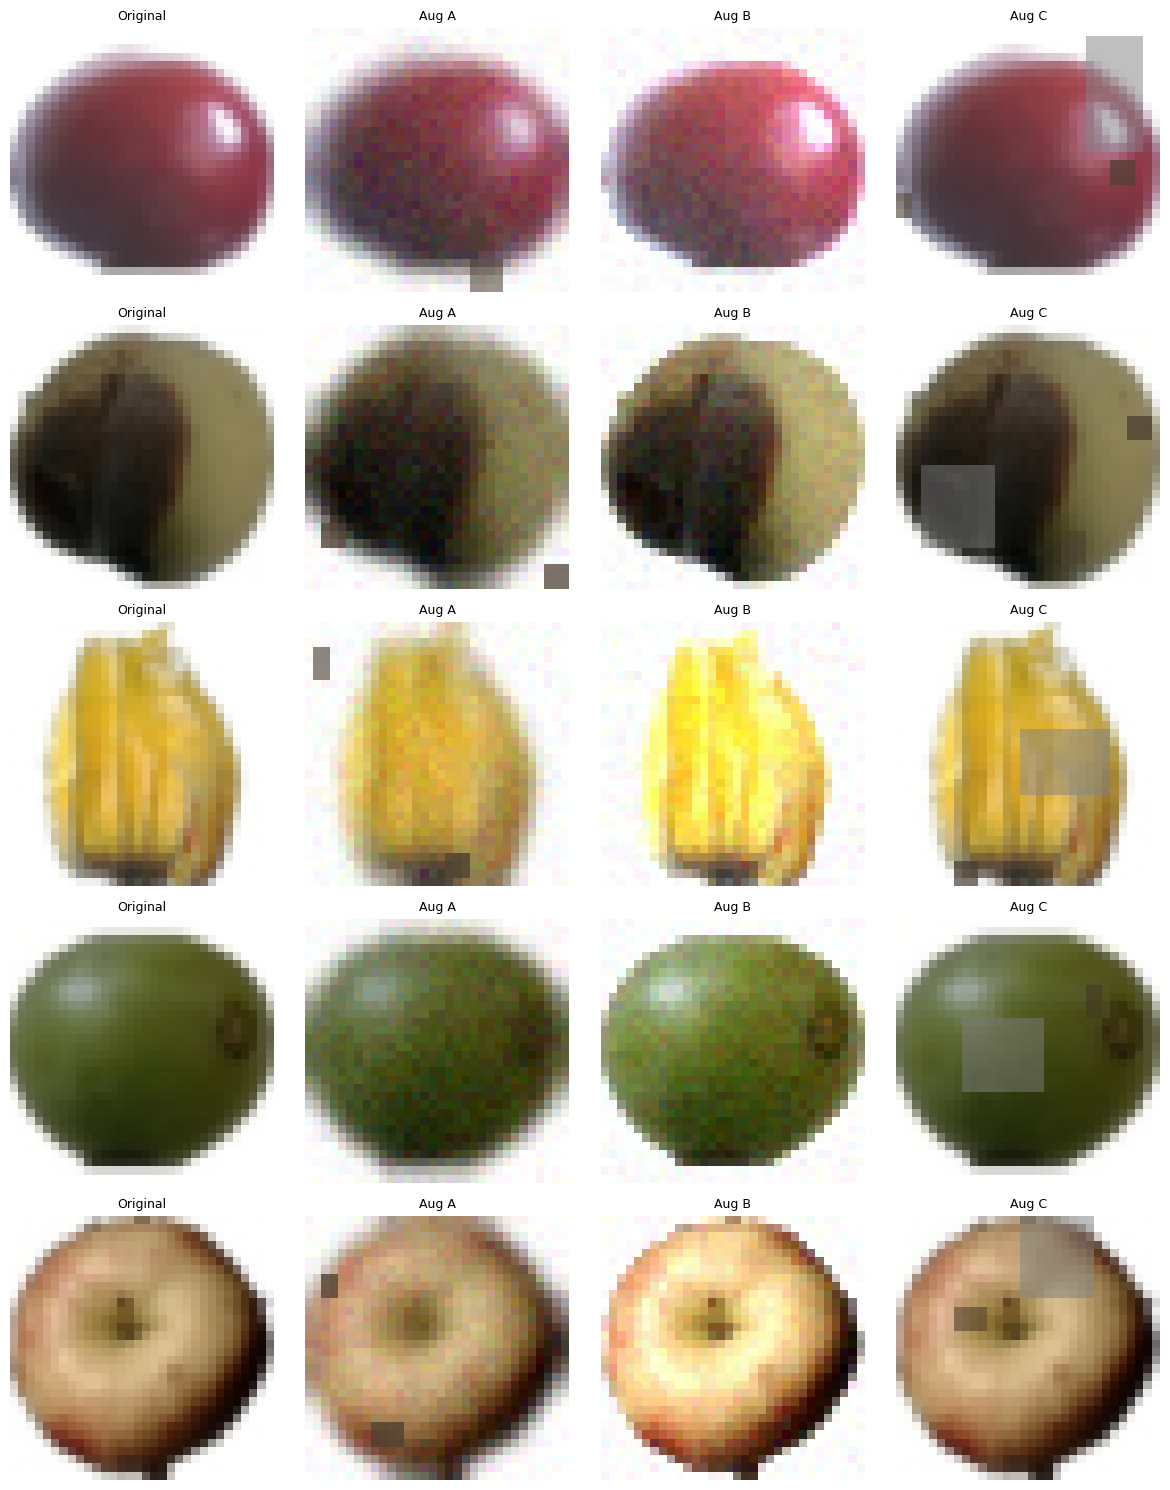

Saved report_assets/figures/fig_09_augmentation_ratio_overview.png


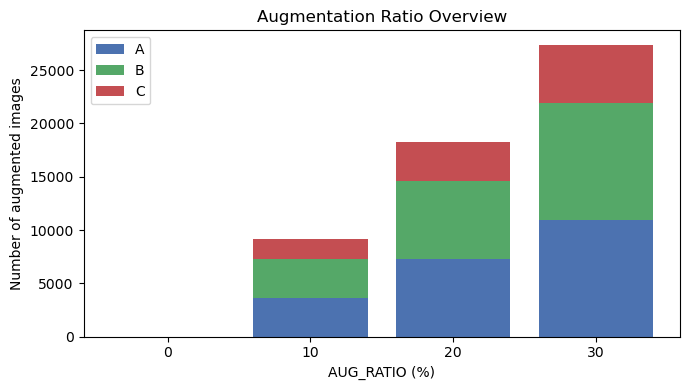

Saved report_assets/tables/table_02_augmentation_counts.csv
Saved report_assets/tables/table_02_augmentation_counts.md


,AUG_RATIO,Total augmented,A count,B count,C count
0,0,0,0,0,0
1,10,9124,3649,3649,1826
2,20,18248,7299,7299,3650
3,30,27372,10948,10948,5476


In [6]:
transform_32 = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
])

def clamp_01(x):
    return torch.clamp(x, 0.0, 1.0)


def add_color_patches(x, num_patches, color, alpha_range=(0.4, 0.7), size_range=(0.05, 0.15)):
    _, H, W = x.shape
    out = x.clone()
    for _ in range(num_patches):
        s = np.random.uniform(size_range[0], size_range[1])
        patch_area = s * H * W / 4
        r = np.random.uniform(0.5, 1.5)
        patch_h = int(math.sqrt(patch_area / r))
        patch_w = int(math.sqrt(patch_area * r))
        patch_h = max(1, min(H, patch_h))
        patch_w = max(1, min(W, patch_w))
        top = np.random.randint(0, H - patch_h + 1)
        left = np.random.randint(0, W - patch_w + 1)
        bottom = top + patch_h
        right = left + patch_w
        alpha = np.random.uniform(alpha_range[0], alpha_range[1])
        patch = out[:, top:bottom, left:right]
        blended = alpha * color + (1 - alpha) * patch
        out[:, top:bottom, left:right] = blended
    return clamp_01(out)


def add_occlusion_patch(x, area_ratio=0.1, color=torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1), alpha=0.5):
    _, H, W = x.shape
    out = x.clone()
    patch_area = area_ratio * H * W
    r = np.random.uniform(0.5, 1.5)
    patch_h = int(math.sqrt(patch_area / r))
    patch_w = int(math.sqrt(patch_area * r))
    patch_h = max(1, min(H, patch_h))
    patch_w = max(1, min(W, patch_w))
    top = np.random.randint(0, H - patch_h + 1)
    left = np.random.randint(0, W - patch_w + 1)
    bottom = top + patch_h
    right = left + patch_w
    patch = out[:, top:bottom, left:right]
    blended = alpha * color + (1 - alpha) * patch
    out[:, top:bottom, left:right] = blended
    return clamp_01(out)


color_dirt = torch.tensor([0.3, 0.25, 0.2]).view(3, 1, 1)
color_bruise = torch.tensor([0.25, 0.2, 0.15]).view(3, 1, 1)


def noise_mild(x):
    return clamp_01(x + torch.randn_like(x) * 0.025)


def dark_mild(x):
    return clamp_01(x * 0.65)


def overexposed_mild(x):
    return clamp_01(x * 1.35)


def dirty_mild(x):
    return add_color_patches(x, num_patches=2, color=color_dirt, alpha_range=(0.5, 0.8), size_range=(0.03, 0.08))


def bruised_mild(x):
    return add_color_patches(x, num_patches=1, color=color_bruise, alpha_range=(0.4, 0.7), size_range=(0.03, 0.08))


def occlusion_small(x):
    return add_occlusion_patch(x, area_ratio=0.10, alpha=0.5)


blur_medium = T.GaussianBlur(kernel_size=5, sigma=1.0)


def scenario_A(x):
    x = blur_medium(x)
    x = noise_mild(x)
    if np.random.rand() < 0.7:
        x = dirty_mild(x)
    return x


def scenario_B(x):
    if np.random.rand() < 0.5:
        x = dark_mild(x)
    else:
        x = overexposed_mild(x)
    x = noise_mild(x)
    return x


def scenario_C(x):
    x = occlusion_small(x)
    if np.random.rand() < 0.5:
        x = bruised_mild(x)
    else:
        x = dirty_mild(x)
    return x


scenario_map = {
    "clean": lambda x: x,
    "scenario_A": scenario_A,
    "scenario_B": scenario_B,
    "scenario_C": scenario_C,
}

example_paths = rng.choice([p for p, _ in train_full.samples], size=5, replace=False)

fig, axes = plt.subplots(len(example_paths), 4, figsize=(12, 3 * len(example_paths)))
if len(example_paths) == 1:
    axes = np.expand_dims(axes, axis=0)

for row, path in enumerate(example_paths):
    img = Image.open(path).convert("RGB")
    img_t = transform_32(img)
    variants = [
        ("Original", img_t),
        ("Aug A", scenario_A(img_t.clone())),
        ("Aug B", scenario_B(img_t.clone())),
        ("Aug C", scenario_C(img_t.clone())),
    ]
    for col, (title, tensor_img) in enumerate(variants):
        axes[row, col].imshow(np.transpose(tensor_img.numpy(), (1, 2, 0)))
        axes[row, col].set_title(title, fontsize=9)
        axes[row, col].axis("off")

plt.tight_layout()
save_fig("fig_08_augmentation_scenarios_ABC.png")
plt.show()

aug_ratios = [0.0, 0.10, 0.20, 0.30]
base_train = len(train_dataset)
rows = []
for r in aug_ratios:
    n_aug = int(base_train * r)
    a = int(n_aug * 0.4)
    b = int(n_aug * 0.4)
    c = n_aug - a - b
    rows.append({
        "AUG_RATIO": int(r * 100),
        "Total augmented": n_aug,
        "A count": a,
        "B count": b,
        "C count": c,
    })

aug_df = pd.DataFrame(rows)

plt.figure(figsize=(7, 4))
plt.bar(aug_df["AUG_RATIO"].astype(str), aug_df["A count"], label="A", color="#4C72B0")
plt.bar(aug_df["AUG_RATIO"].astype(str), aug_df["B count"], bottom=aug_df["A count"], label="B", color="#55A868")
plt.bar(aug_df["AUG_RATIO"].astype(str), aug_df["C count"], bottom=aug_df["A count"] + aug_df["B count"], label="C", color="#C44E52")
plt.title("Augmentation Ratio Overview")
plt.xlabel("AUG_RATIO (%)")
plt.ylabel("Number of augmented images")
plt.legend()
plt.tight_layout()
save_fig("fig_09_augmentation_ratio_overview.png")
plt.show()

save_table(aug_df, "table_02_augmentation_counts")
aug_df

## 3. HSV Color Histogram Features

Saved report_assets/figures/fig_10_hsv_hist_single_image.png


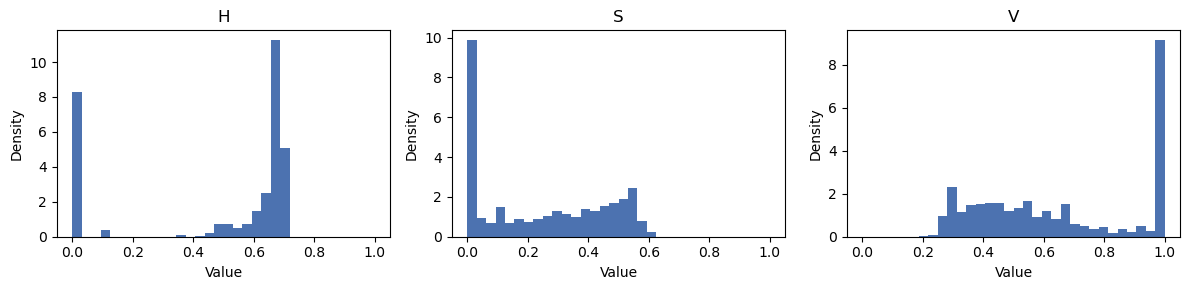

Saved report_assets/figures/fig_11_avg_h_hist_by_class.png


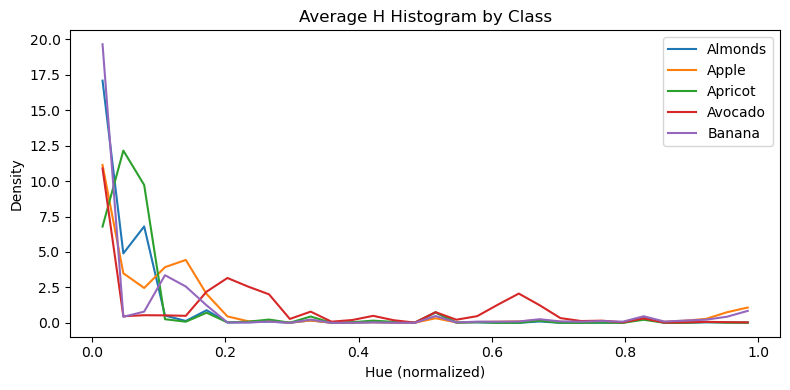

Saved report_assets/figures/fig_12_pca_histograms_2d_scatter.png


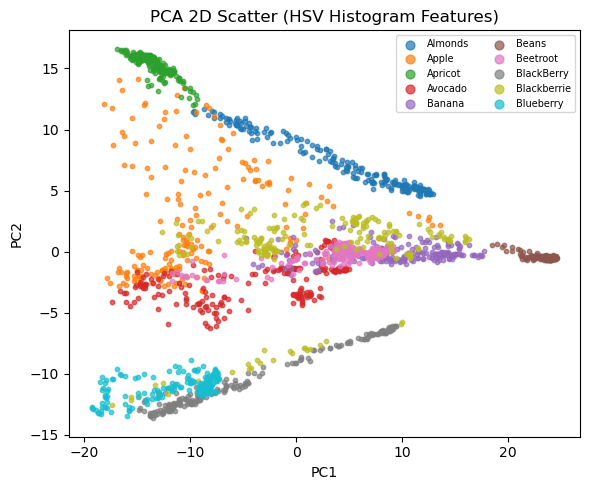

In [7]:
HIST_BINS = 32

def color_hist_features(X, bins=HIST_BINS, img_shape=(3, 32, 32)):
    n_samples = X.shape[0]
    feats = np.zeros((n_samples, 3 * bins), dtype=np.float32)
    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    for i in range(n_samples):
        img = X[i].reshape(img_shape)
        img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0.0, 1.0)
        img_hsv = (img * 255.0).astype(np.uint8)
        img_hsv = cv2.cvtColor(img_hsv, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(img_hsv)
        hists = []
        for channel in (h, s, v):
            ch_norm = channel.astype(np.float32) / 255.0
            hist, _ = np.histogram(ch_norm.ravel(), bins=bin_edges, density=True)
            hists.append(hist)
        feats[i] = np.concatenate(hists)
    return feats

single_path = example_paths[0]
img = load_image_array(single_path, size=32)
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

bins = 32
bin_edges = np.linspace(0.0, 1.0, bins + 1)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, channel, name in zip(axes, [0, 1, 2], ["H", "S", "V"]):
    ch = img_hsv[:, :, channel].astype(np.float32) / 255.0
    hist, _ = np.histogram(ch.ravel(), bins=bin_edges, density=True)
    ax.bar(centers, hist, width=1.0 / bins, color="#4C72B0")
    ax.set_title(name)
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
plt.tight_layout()
save_fig("fig_10_hsv_hist_single_image.png")
plt.show()

avg_h_classes = label_list[:5]
if len(avg_h_classes) > 5:
    avg_h_classes = avg_h_classes[:5]

mean_h = {}
for cls in avg_h_classes:
    paths = [p for p, lbl in train_full.samples if lbl == cls]
    paths = rng.choice(paths, size=min(200, len(paths)), replace=False)
    hists = []
    for path in paths:
        img = load_image_array(path, size=32)
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h = hsv[:, :, 0].astype(np.float32) / 180.0
        hist, _ = np.histogram(h.ravel(), bins=bin_edges, density=True)
        hists.append(hist)
    mean_h[cls] = np.mean(np.stack(hists, axis=0), axis=0)

plt.figure(figsize=(8, 4))
for cls, hist in mean_h.items():
    plt.plot(centers, hist, label=cls)
plt.title("Average H Histogram by Class")
plt.xlabel("Hue (normalized)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
save_fig("fig_11_avg_h_hist_by_class.png")
plt.show()

hist_classes = label_list[:10]
per_class = 200
hist_paths = []
hist_labels = []
for cls in hist_classes:
    paths = [p for p, lbl in train_full.samples if lbl == cls]
    paths = rng.choice(paths, size=min(per_class, len(paths)), replace=False)
    hist_paths.extend(paths)
    hist_labels.extend([cls] * len(paths))

X_hist = []
for path in hist_paths:
    img = load_image_array(path, size=32)
    X_hist.append(np.transpose(img, (2, 0, 1)) / 255.0)

X_hist = np.stack(X_hist, axis=0)
X_hist_feats = color_hist_features(X_hist, bins=HIST_BINS, img_shape=(3, 32, 32))

pca_hist = PCA(n_components=2, random_state=RANDOM_STATE)
X_hist_pca = pca_hist.fit_transform(X_hist_feats)

plt.figure(figsize=(6, 5))
for cls in hist_classes:
    idx = [i for i, c in enumerate(hist_labels) if c == cls]
    plt.scatter(X_hist_pca[idx, 0], X_hist_pca[idx, 1], s=10, alpha=0.7, label=cls)
plt.title("PCA 2D Scatter (HSV Histogram Features)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(markerscale=2, fontsize=7, ncol=2)
plt.tight_layout()
save_fig("fig_12_pca_histograms_2d_scatter.png")
plt.show()

### 3.1 HSV Feature Extraction Visualization

/var/folders/gl/tjkz5rss25z3v_6dz_r7641c0000gn/T/ipykernel_42977/2461181164.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved report_assets/figures/fig_12b_hsv_feature_extraction.png


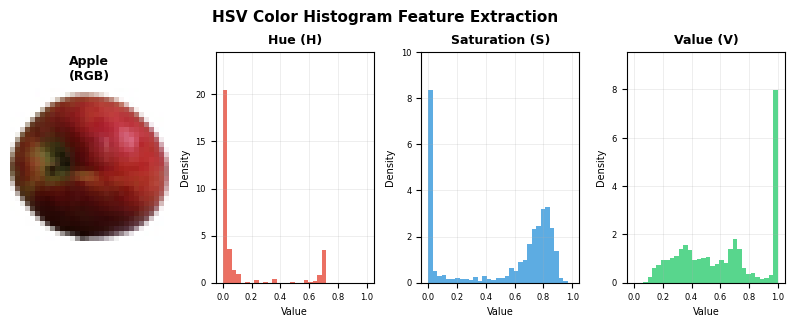

In [10]:
# Select one sample fruit for demonstration
np.random.seed(RANDOM_STATE)
demo_class = "Apple"
demo_paths = [p for p, lbl in train_full.samples if lbl == demo_class]
demo_path = rng.choice(demo_paths, size=1)[0]

# Load image
demo_img = load_image_array(demo_path, size=32)
demo_img_hsv = cv2.cvtColor(demo_img, cv2.COLOR_RGB2HSV)

# Create compact visualization
fig = plt.figure(figsize=(10, 3))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 1], hspace=0.3, wspace=0.3)

# Show RGB image
ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(demo_img)
ax0.set_title(f'{demo_class}\n(RGB)', fontsize=9, fontweight='bold')
ax0.axis('off')

# Plot H, S, V histograms
colors = ['#e74c3c', '#3498db', '#2ecc71']
channel_names = ['Hue (H)', 'Saturation (S)', 'Value (V)']

for i, (channel_name, color) in enumerate(zip(channel_names, colors)):
    ax = fig.add_subplot(gs[0, i + 1])
    ch = demo_img_hsv[:, :, i].astype(np.float32) / 255.0
    hist, _ = np.histogram(ch.ravel(), bins=bin_edges, density=True)
    
    ax.bar(centers, hist, width=1.0/bins, color=color, alpha=0.8, edgecolor='none')
    ax.set_title(channel_name, fontsize=9, fontweight='bold')
    ax.set_xlabel('Value', fontsize=7)
    ax.set_ylabel('Density', fontsize=7)
    ax.tick_params(labelsize=6)
    ax.grid(alpha=0.3, linewidth=0.5)
    ax.set_ylim(0, max(hist) * 1.2)

plt.suptitle('HSV Color Histogram Feature Extraction', fontsize=11, fontweight='bold', y=1.02)
plt.tight_layout()
save_fig("fig_12b_hsv_feature_extraction.png")
plt.show()

In [ ]:

def load_pca_components(path):
    if os.path.exists(path):
        pca = joblib.load(path)
        return pca.n_components_
    return None

pca_8 = load_pca_components("saved_models/pca_8x8.joblib")
pca_16 = load_pca_components("saved_models/pca_16x16.joblib")
pca_32 = load_pca_components("saved_models/pca_32x32.joblib")
pca_hist_16 = load_pca_components("saved_models/pca_augmented_colorhist_32x32.joblib")
pca_hist_32 = load_pca_components("saved_models/pca_augmented_colorhist32bins_32x32_stacking.joblib")

feature_table = pd.DataFrame([
    {"Feature": "Pixels 8x8", "Raw dim": 3 * 8 * 8, "PCA components": pca_8, "Notes": "color + rough shape"},
    {"Feature": "Pixels 16x16", "Raw dim": 3 * 16 * 16, "PCA components": pca_16, "Notes": "color + rough shape"},
    {"Feature": "Pixels 32x32", "Raw dim": 3 * 32 * 32, "PCA components": pca_32, "Notes": "color + rough shape"},
    {"Feature": "HSV hist 16 bins", "Raw dim": 3 * 16, "PCA components": pca_hist_16, "Notes": "global color"},
    {"Feature": "HSV hist 32 bins", "Raw dim": 3 * 32, "PCA components": pca_hist_32, "Notes": "global color"},
])

save_table(feature_table, "table_03_feature_dimensions")
feature_table

## 4. PCA Analysis (Pixels and Histograms)

Saved report_assets/figures/fig_13_scree_pixels_32x32.png


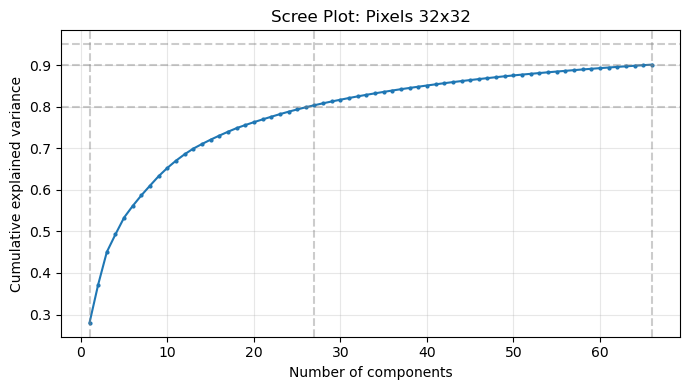

Saved report_assets/figures/fig_14_scree_hist_32bins.png


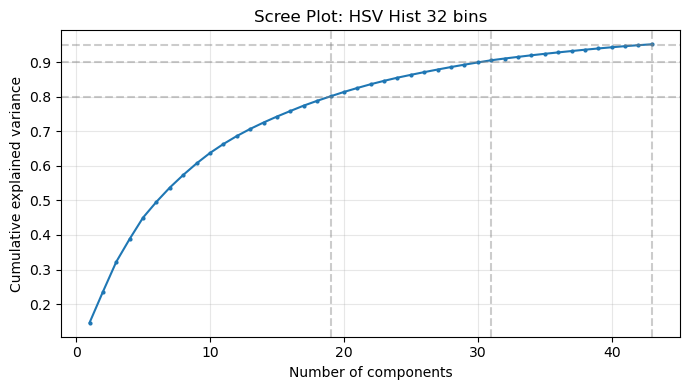

Saved report_assets/figures/fig_15_pca_pixels_embedding.png


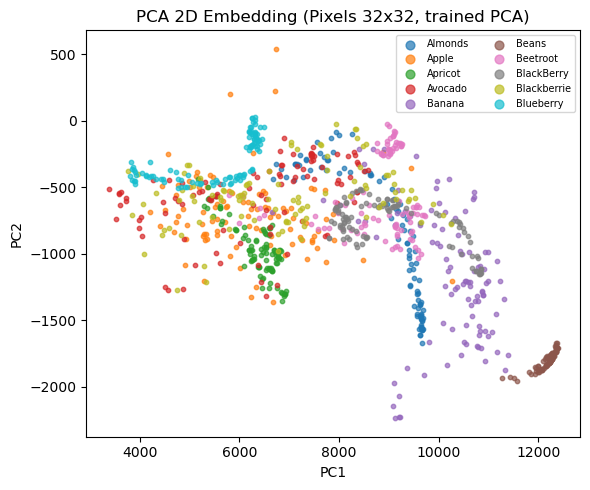

Saved report_assets/figures/fig_16_pca_hist_embedding.png


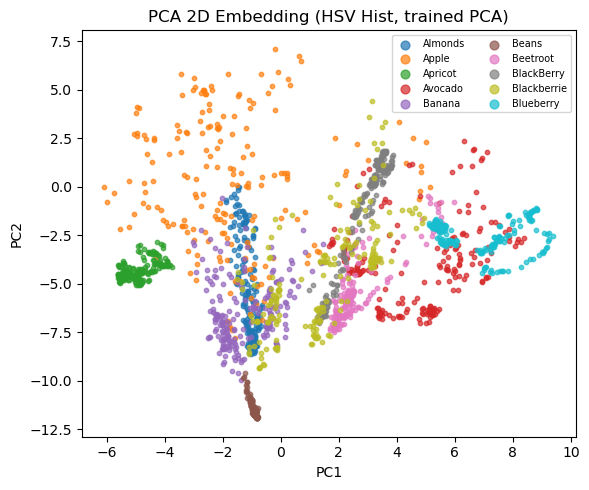

In [ ]:
def plot_scree(pca, title, filename):
    explained = pca.explained_variance_ratio_
    cumsum = np.cumsum(explained)
    thresholds = [0.8, 0.9, 0.95]
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(range(1, len(cumsum) + 1), cumsum, marker="o", markersize=2)
    for t in thresholds:
        k = np.argmax(cumsum >= t) + 1
        ax.axhline(t, color="gray", linestyle="--", alpha=0.4)
        ax.axvline(k, color="gray", linestyle="--", alpha=0.4)
    ax.set_title(title)
    ax.set_xlabel("Number of components")
    ax.set_ylabel("Cumulative explained variance")
    ax.grid(alpha=0.3)
    plt.tight_layout()
    save_fig(filename)
    plt.show()

pca_pixels_32 = None
if os.path.exists("saved_models/pca_32x32.joblib"):
    pca_pixels_32 = joblib.load("saved_models/pca_32x32.joblib")

if pca_pixels_32 is not None:
    plot_scree(pca_pixels_32, "Scree Plot: Pixels 32x32", "fig_13_scree_pixels_32x32.png")

pca_hist_32_model = None
if os.path.exists("saved_models/pca_augmented_colorhist32bins_32x32_stacking.joblib"):
    pca_hist_32_model = joblib.load("saved_models/pca_augmented_colorhist32bins_32x32_stacking.joblib")

if pca_hist_32_model is not None:
    plot_scree(pca_hist_32_model, "Scree Plot: HSV Hist 32 bins", "fig_14_scree_hist_32bins.png")

if pca_pixels_32 is not None:
    X_pixels_emb = pca_pixels_32.transform(X_pixels)
    plt.figure(figsize=(6, 5))
    for cls in pca_classes:
        idx = [i for i, c in enumerate(labels_pca) if c == cls]
        plt.scatter(X_pixels_emb[idx, 0], X_pixels_emb[idx, 1], s=10, alpha=0.7, label=cls)
    plt.title("PCA 2D Embedding (Pixels 32x32, trained PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(markerscale=2, fontsize=7, ncol=2)
    plt.tight_layout()
    save_fig("fig_15_pca_pixels_embedding.png")
    plt.show()

if pca_hist_32_model is not None:
    X_hist_emb = pca_hist_32_model.transform(X_hist_feats)
    plt.figure(figsize=(6, 5))
    for cls in hist_classes:
        idx = [i for i, c in enumerate(hist_labels) if c == cls]
        plt.scatter(X_hist_emb[idx, 0], X_hist_emb[idx, 1], s=10, alpha=0.7, label=cls)
    plt.title("PCA 2D Embedding (HSV Hist, trained PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(markerscale=2, fontsize=7, ncol=2)
    plt.tight_layout()
    save_fig("fig_16_pca_hist_embedding.png")
    plt.show()

## 5. Classifier Performance: Baselines and Augmentation

Test: 43442 images, 79 classes
Test: 43442 images, 79 classes
Test: 43442 images, 79 classes
Saved report_assets/tables/table_04_baseline_resolution_pixels.csv
Saved report_assets/tables/table_04_baseline_resolution_pixels.md
Saved report_assets/figures/fig_17_accuracy_vs_resolution.png


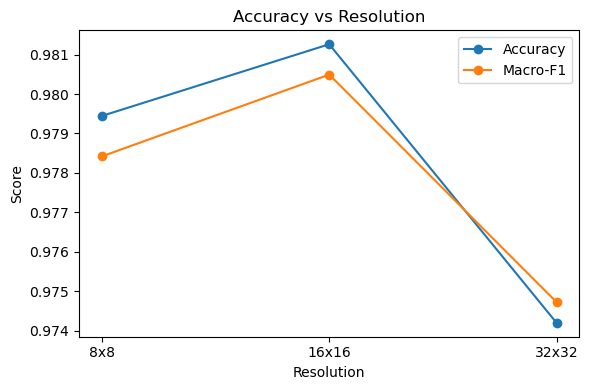

Test: 43442 images, 79 classes
Test: 43442 images, 79 classes
Saved report_assets/tables/table_05_augmentation_effect_primary.csv
Saved report_assets/tables/table_05_augmentation_effect_primary.md
Saved report_assets/figures/fig_18_performance_vs_augmentation.png


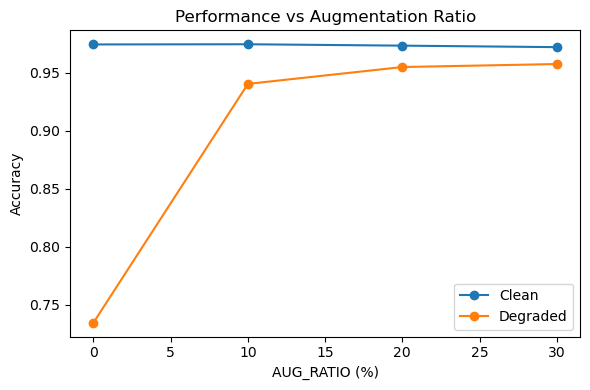

Saved report_assets/tables/table_06_pixels_vs_hist_pipelines.csv
Saved report_assets/tables/table_06_pixels_vs_hist_pipelines.md
Saved report_assets/figures/fig_19_pixels_vs_hist_accuracy.png


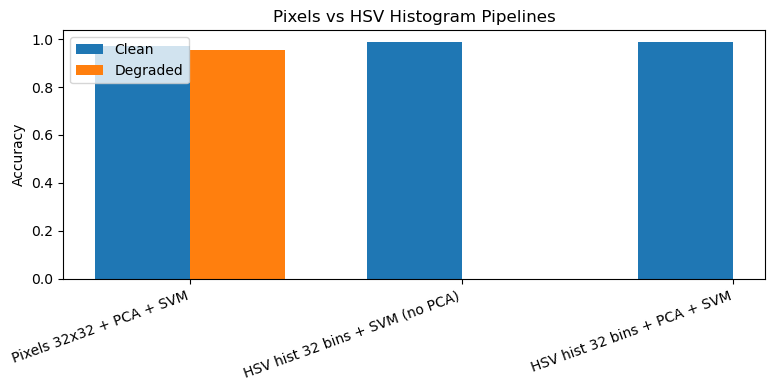

Test: 43442 images, 79 classes
Saved report_assets/figures/fig_20_confusion_matrix_clean.png


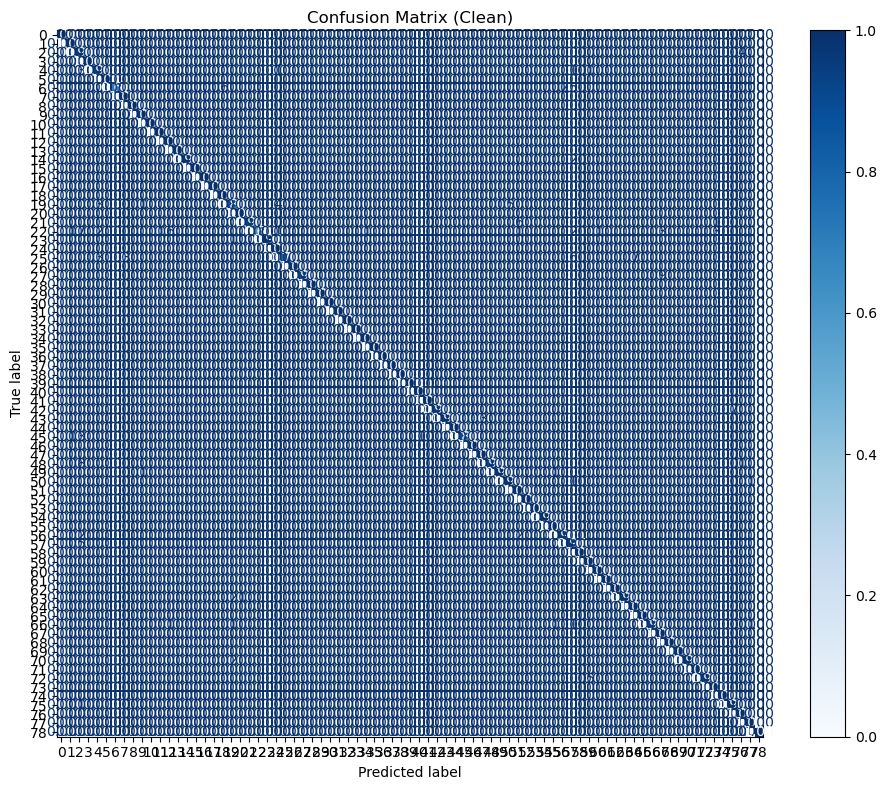

Test: 43442 images, 79 classes


KeyboardInterrupt: 

In [ ]:
def extract_numpy(loader, label_to_idx):
    X_list = []
    y_list = []
    for imgs, labels in loader:
        X_list.append(imgs.numpy())
        y_list.extend([label_to_idx[lbl] for lbl in labels])
    X = np.concatenate(X_list, axis=0)
    y = np.array(y_list)
    return X, y


def load_test_numpy(size, label_to_idx):
    transform = T.Compose([
        T.Resize((size, size)),
        T.ToTensor(),
    ])
    test_ds = Fruit360FolderDataset(TEST_DIR, transform=transform, variety=False)
    test_loader = DataLoader(test_ds, batch_size=100, shuffle=False)
    X_test, y_test = extract_numpy(test_loader, label_to_idx)
    return X_test, y_test


def evaluate_pca_svm(X_test, y_test, scaler, pca, svm):
    X_flat = X_test.reshape(X_test.shape[0], -1)
    X_sc = scaler.transform(X_flat)
    if pca is not None:
        X_sc = pca.transform(X_sc)
    preds = svm.predict(X_sc)
    acc = accuracy_score(y_test, preds)
    macro_f1 = f1_score(y_test, preds, average="macro")
    return acc, macro_f1, preds


def load_model_bundle(prefix):
    scaler_path = f"saved_models/scaler_{prefix}.joblib"
    pca_path = f"saved_models/pca_{prefix}.joblib"
    svm_path = f"saved_models/svm_{prefix}.joblib"
    if not (os.path.exists(scaler_path) and os.path.exists(svm_path)):
        return None
    scaler = joblib.load(scaler_path)
    pca = joblib.load(pca_path) if os.path.exists(pca_path) else None
    svm = joblib.load(svm_path)
    return scaler, pca, svm


baseline_rows = []
for size in [8, 16, 32]:
    bundle = load_model_bundle(f"{size}x{size}")
    if bundle is None:
        continue
    scaler, pca, svm = bundle
    X_test, y_test = load_test_numpy(size, train_full.label_to_idx)
    start = time.time()
    acc, macro_f1, _ = evaluate_pca_svm(X_test, y_test, scaler, pca, svm)
    test_time = time.time() - start
    baseline_rows.append({
        "Resolution": f"{size}x{size}",
        "Raw dim": 3 * size * size,
        "PCA components": pca.n_components_ if pca is not None else None,
        "Clean test accuracy": acc,
        "Macro-F1": macro_f1,
        "Test time (s)": test_time,
    })

baseline_df = pd.DataFrame(baseline_rows)
save_table(baseline_df, "table_04_baseline_resolution_pixels")
baseline_df

if len(baseline_df) > 0:
    plt.figure(figsize=(6, 4))
    plt.plot(baseline_df["Resolution"], baseline_df["Clean test accuracy"], marker="o", label="Accuracy")
    if baseline_df["Macro-F1"].notna().all():
        plt.plot(baseline_df["Resolution"], baseline_df["Macro-F1"], marker="o", label="Macro-F1")
    plt.title("Accuracy vs Resolution")
    plt.xlabel("Resolution")
    plt.ylabel("Score")
    plt.legend()
    plt.tight_layout()
    save_fig("fig_17_accuracy_vs_resolution.png")
    plt.show()


def load_ratio_bundle(ratio):
    if ratio == 0:
        suffix = "32x32"
    elif ratio == 10:
        suffix = "augmented_32x32"
    elif ratio == 20:
        suffix = "augmented_32x32_20%"
    elif ratio == 30:
        suffix = "augmented_32x32_30%"
    else:
        return None
    scaler_path = f"saved_models/scaler_{suffix}.joblib"
    pca_path = f"saved_models/pca_{suffix}.joblib"
    svm_path = f"saved_models/svm_{suffix}.joblib"
    if not (os.path.exists(scaler_path) and os.path.exists(svm_path)):
        return None
    scaler = joblib.load(scaler_path)
    pca = joblib.load(pca_path) if os.path.exists(pca_path) else None
    svm = joblib.load(svm_path)
    return scaler, pca, svm


def evaluate_mixed_scenarios(test_loader, label_to_idx, scaler, pca, svm, probs):
    np.random.seed(RANDOM_STATE)
    torch.manual_seed(RANDOM_STATE)

    scenario_names = list(scenario_map.keys())
    all_preds = []
    all_labels = []

    for imgs, labels in test_loader:
        imgs_batch = []
        labels_idx_batch = []
        for img, lbl_str in zip(imgs, labels):
            r = np.random.rand()
            if r < probs[0]:
                scenario = scenario_names[0]
            elif r < probs[0] + probs[1]:
                scenario = scenario_names[1]
            elif r < probs[0] + probs[1] + probs[2]:
                scenario = scenario_names[2]
            else:
                scenario = scenario_names[3]
            x = scenario_map[scenario](img)
            imgs_batch.append(x.unsqueeze(0))
            labels_idx_batch.append(label_to_idx[lbl_str])

        imgs_batch = torch.cat(imgs_batch, dim=0)
        X = imgs_batch.numpy().reshape(imgs_batch.shape[0], -1)
        X = scaler.transform(X)
        if pca is not None:
            X = pca.transform(X)
        preds = svm.predict(X)
        all_preds.append(preds)
        all_labels.append(np.array(labels_idx_batch))

    y_pred = np.concatenate(all_preds, axis=0)
    y_true = np.concatenate(all_labels, axis=0)
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    return acc, macro_f1


ratio_rows = []
X_test_32, y_test_32 = load_test_numpy(32, train_full.label_to_idx)

transform_test = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
])

test_ds_32 = Fruit360FolderDataset(TEST_DIR, transform=transform_test, variety=False)
test_loader_32 = DataLoader(test_ds_32, batch_size=100, shuffle=False)

for ratio in [0, 10, 20, 30]:
    bundle = load_ratio_bundle(ratio)
    if bundle is None:
        ratio_rows.append({
            "AUG_RATIO": ratio,
            "Train size": len(train_dataset) + int(len(train_dataset) * ratio / 100),
            "Clean test accuracy": np.nan,
            "Degraded test accuracy": np.nan,
            "Macro-F1 clean": np.nan,
            "Macro-F1 degraded": np.nan,
        })
        continue
    scaler, pca, svm = bundle
    acc_clean, f1_clean, _ = evaluate_pca_svm(X_test_32, y_test_32, scaler, pca, svm)
    acc_deg, f1_deg = evaluate_mixed_scenarios(
        test_loader_32,
        train_full.label_to_idx,
        scaler,
        pca,
        svm,
        probs=[0.6, 0.15, 0.15, 0.10],
    )
    ratio_rows.append({
        "AUG_RATIO": ratio,
        "Train size": len(train_dataset) + int(len(train_dataset) * ratio / 100),
        "Clean test accuracy": acc_clean,
        "Degraded test accuracy": acc_deg,
        "Macro-F1 clean": f1_clean,
        "Macro-F1 degraded": f1_deg,
    })

ratio_df = pd.DataFrame(ratio_rows)
save_table(ratio_df, "table_05_augmentation_effect_primary")
ratio_df

if ratio_df["Clean test accuracy"].notna().any():
    plt.figure(figsize=(6, 4))
    plt.plot(ratio_df["AUG_RATIO"], ratio_df["Clean test accuracy"], marker="o", label="Clean")
    plt.plot(ratio_df["AUG_RATIO"], ratio_df["Degraded test accuracy"], marker="o", label="Degraded")
    plt.title("Performance vs Augmentation Ratio")
    plt.xlabel("AUG_RATIO (%)")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    save_fig("fig_18_performance_vs_augmentation.png")
    plt.show()


def load_hist_bundle(kind):
    if kind == "hist16":
        scaler_path = "saved_models/scaler_augmented_colorhist_32x32.joblib"
        svm_path = "saved_models/svm_augmented_colorhist_32x32.joblib"
        pca_path = "saved_models/pca_augmented_colorhist_32x32.joblib"
    elif kind == "hist32":
        scaler_path = "saved_models/scaler_augmented_colorhist32bins_32x32_stacking.joblib"
        svm_path = "saved_models/svm_augmented_colorhist32bins_32x32_stacking.joblib"
        pca_path = "saved_models/pca_augmented_colorhist32bins_32x32_stacking.joblib"
    else:
        return None
    if not (os.path.exists(scaler_path) and os.path.exists(svm_path)):
        return None
    scaler = joblib.load(scaler_path)
    svm = joblib.load(svm_path)
    pca = joblib.load(pca_path) if pca_path and os.path.exists(pca_path) else None
    return scaler, pca, svm


def evaluate_hist_pipeline(bins, scaler, pca, svm, X_test_tensor, y_test):
    X_hist = color_hist_features(X_test_tensor, bins=bins, img_shape=(3, 32, 32))
    X_sc = scaler.transform(X_hist)
    if pca is not None:
        X_sc = pca.transform(X_sc)
    preds = svm.predict(X_sc)
    acc = accuracy_score(y_test, preds)
    return acc


pipelines = []

pixels_bundle = load_ratio_bundle(20)
if pixels_bundle is not None:
    scaler, pca, svm = pixels_bundle
    acc_clean, _, _ = evaluate_pca_svm(X_test_32, y_test_32, scaler, pca, svm)
    acc_deg, _ = evaluate_mixed_scenarios(
        test_loader_32,
        train_full.label_to_idx,
        scaler,
        pca,
        svm,
        probs=[0.6, 0.15, 0.15, 0.10],
    )
    pipelines.append({
        "Pipeline": "Pixels 32x32 + PCA + SVM",
        "Raw dim": 3 * 32 * 32,
        "PCA components": pca.n_components_ if pca is not None else None,
        "Clean accuracy": acc_clean,
        "Degraded accuracy": acc_deg,
    })

hist16_bundle = load_hist_bundle("hist16")
if hist16_bundle is not None:
    scaler, pca, svm = hist16_bundle
    acc_clean = evaluate_hist_pipeline(32, scaler, pca, svm, X_test_32, y_test_32)
    pipelines.append({
        "Pipeline": "HSV hist 32 bins + SVM (no PCA)",
        "Raw dim": 3 * 32,
        "PCA components": pca.n_components_ if pca is not None else None,
        "Clean accuracy": acc_clean,
        "Degraded accuracy": np.nan,
    })

hist32_bundle = load_hist_bundle("hist32")
if hist32_bundle is not None:
    scaler, pca, svm = hist32_bundle
    acc_clean = evaluate_hist_pipeline(32, scaler, pca, svm, X_test_32, y_test_32)
    pipelines.append({
        "Pipeline": "HSV hist 32 bins + PCA + SVM",
        "Raw dim": 3 * 32,
        "PCA components": pca.n_components_ if pca is not None else None,
        "Clean accuracy": acc_clean,
        "Degraded accuracy": np.nan,
    })

pipelines_df = pd.DataFrame(pipelines)
save_table(pipelines_df, "table_06_pixels_vs_hist_pipelines")
pipelines_df

if len(pipelines_df) > 0:
    fig, ax = plt.subplots(figsize=(8, 4))
    x = np.arange(len(pipelines_df))
    width = 0.35
    ax.bar(x - width / 2, pipelines_df["Clean accuracy"], width, label="Clean")
    if "Degraded accuracy" in pipelines_df:
        ax.bar(x + width / 2, pipelines_df["Degraded accuracy"], width, label="Degraded")
    ax.set_xticks(x)
    ax.set_xticklabels(pipelines_df["Pipeline"], rotation=20, ha="right")
    ax.set_ylabel("Accuracy")
    ax.set_title("Pixels vs HSV Histogram Pipelines")
    ax.legend()
    plt.tight_layout()
    save_fig("fig_19_pixels_vs_hist_accuracy.png")
    plt.show()

best_model = None
if len(baseline_df) > 0:
    best_row = baseline_df.sort_values("Clean test accuracy", ascending=False).iloc[0]
    best_size = int(best_row["Resolution"].split("x")[0])
    bundle = load_model_bundle(f"{best_size}x{best_size}")
    if bundle is not None:
        best_model = (best_size,) + bundle

if best_model is not None:
    best_size, scaler, pca, svm = best_model
    X_test_best, y_test_best = load_test_numpy(best_size, train_full.label_to_idx)
    _, _, preds_clean = evaluate_pca_svm(X_test_best, y_test_best, scaler, pca, svm)
    cm_clean = confusion_matrix(y_test_best, preds_clean, normalize="true")
    disp = ConfusionMatrixDisplay(cm_clean)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap="Blues", values_format=".2f", colorbar=True)
    plt.title("Confusion Matrix (Clean)")
    plt.tight_layout()
    save_fig("fig_20_confusion_matrix_clean.png")
    plt.show()

    transform_best = T.Compose([
        T.Resize((best_size, best_size)),
        T.ToTensor(),
    ])
    test_ds_best = Fruit360FolderDataset(TEST_DIR, transform=transform_best, variety=False)
    test_loader_best = DataLoader(test_ds_best, batch_size=100, shuffle=False)

    all_preds = []
    all_labels = []
    for imgs, labels in test_loader_best:
        imgs_batch = []
        labels_idx_batch = []
        for img, lbl_str in zip(imgs, labels):
            x = scenario_A(img)
            imgs_batch.append(x.unsqueeze(0))
            labels_idx_batch.append(train_full.label_to_idx[lbl_str])
        imgs_batch = torch.cat(imgs_batch, dim=0)
        X = imgs_batch.numpy().reshape(imgs_batch.shape[0], -1)
        X = scaler.transform(X)
        if pca is not None:
            X = pca.transform(X)
        preds = svm.predict(X)
        all_preds.append(preds)
        all_labels.append(np.array(labels_idx_batch))

    preds_degraded = np.concatenate(all_preds, axis=0)
    labels_degraded = np.concatenate(all_labels, axis=0)
    cm_deg = confusion_matrix(labels_degraded, preds_degraded, normalize="true")
    disp = ConfusionMatrixDisplay(cm_deg)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap="Blues", values_format=".2f", colorbar=True)
    plt.title("Confusion Matrix (Scenario A)")
    plt.tight_layout()
    save_fig("fig_21_confusion_matrix_degraded.png")
    plt.show()

## 6. Robustness Analysis (Global and Per-Class)

Saved report_assets/tables/table_07_global_robustness_summary.csv
Saved report_assets/tables/table_07_global_robustness_summary.md
Saved report_assets/figures/fig_22_accuracy_heatmap_models_vs_degradations.png


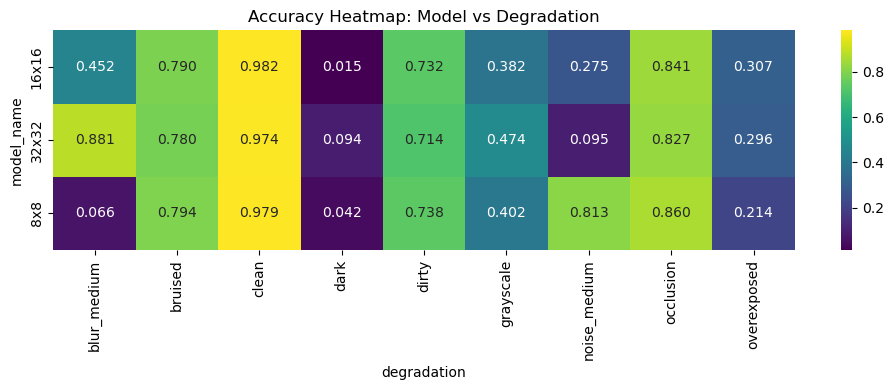

Saved report_assets/figures/fig_23_accuracy_vs_degradation_lines.png


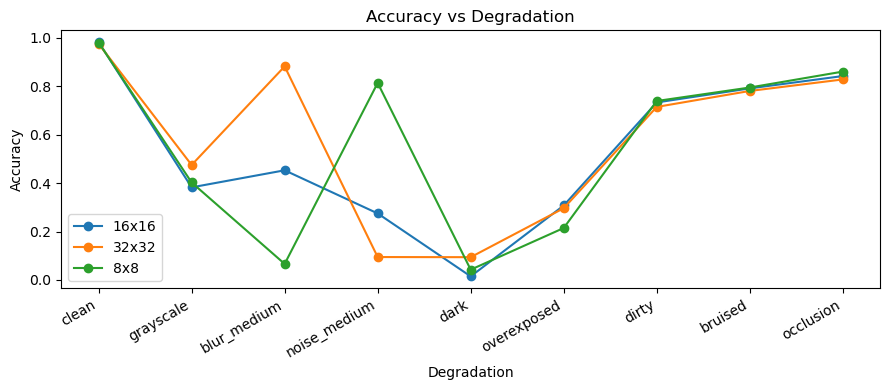

Saved report_assets/figures/fig_24_accuracy_vs_time.png


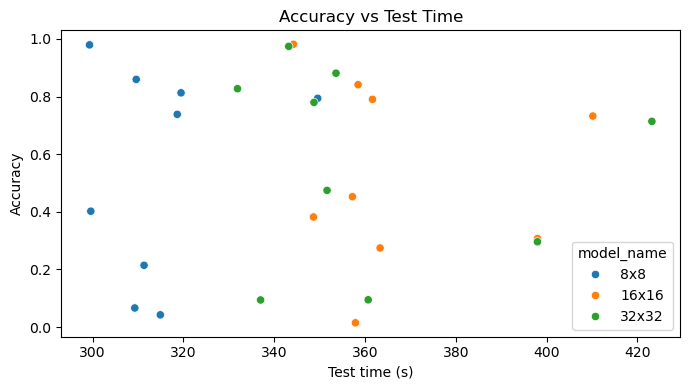

Saved report_assets/tables/table_08_per_class_robustness_top_bottom.csv
Saved report_assets/tables/table_08_per_class_robustness_top_bottom.md
Saved report_assets/figures/fig_25_per_class_barplots_degradations.png


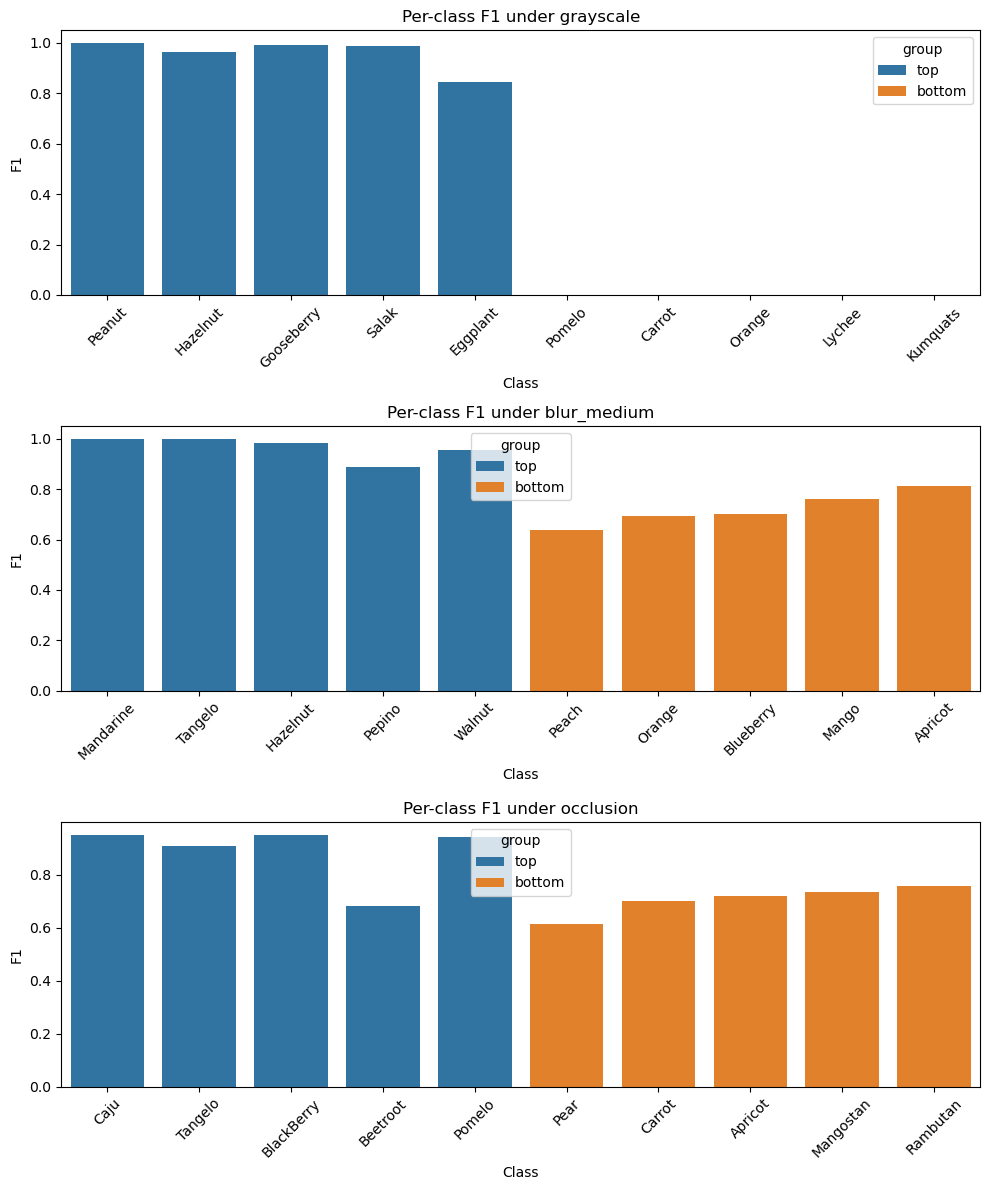

Saved report_assets/figures/fig_26_drop_distribution_per_class.png


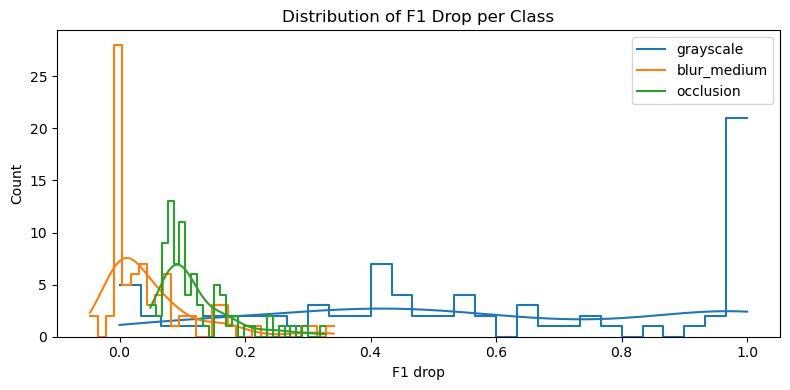

In [ ]:
global_path = "results/robustness_global.csv"
per_class_path = "results/robustness_per_class.csv"

robust_global = pd.read_csv(global_path)
robust_per_class = pd.read_csv(per_class_path)

cols = ["model_name", "degradation", "accuracy", "macro_f1", "test_time_sec"]
robust_summary = robust_global[cols].copy()
save_table(robust_summary, "table_07_global_robustness_summary")
robust_summary.head()

heatmap_df = robust_global.pivot_table(
    index="model_name",
    columns="degradation",
    values="accuracy",
)

plt.figure(figsize=(10, 4))
sns.heatmap(heatmap_df, annot=True, fmt=".3f", cmap="viridis")
plt.title("Accuracy Heatmap: Model vs Degradation")
plt.tight_layout()
save_fig("fig_22_accuracy_heatmap_models_vs_degradations.png")
plt.show()

order = ["clean", "grayscale", "blur_medium", "noise_medium", "dark", "overexposed", "dirty", "bruised", "occlusion"]
line_df = robust_global.copy()
line_df["degradation"] = pd.Categorical(line_df["degradation"], categories=order, ordered=True)
line_df = line_df.sort_values(["model_name", "degradation"])

plt.figure(figsize=(9, 4))
for model in sorted(line_df["model_name"].unique()):
    sub = line_df[line_df["model_name"] == model]
    plt.plot(sub["degradation"], sub["accuracy"], marker="o", label=model)
plt.title("Accuracy vs Degradation")
plt.xlabel("Degradation")
plt.ylabel("Accuracy")
plt.xticks(rotation=30, ha="right")
plt.legend()
plt.tight_layout()
save_fig("fig_23_accuracy_vs_degradation_lines.png")
plt.show()

plt.figure(figsize=(7, 4))
sns.scatterplot(data=robust_global, x="test_time_sec", y="accuracy", hue="model_name")
plt.title("Accuracy vs Test Time")
plt.xlabel("Test time (s)")
plt.ylabel("Accuracy")
plt.tight_layout()
save_fig("fig_24_accuracy_vs_time.png")
plt.show()

main_model = "32x32"
selected_degradations = ["grayscale", "blur_medium", "occlusion"]

clean_df = robust_per_class[(robust_per_class["model_name"] == main_model) & (robust_per_class["degradation"] == "clean")]

rows = []
for deg in selected_degradations:
    deg_df = robust_per_class[(robust_per_class["model_name"] == main_model) & (robust_per_class["degradation"] == deg)]
    merged = clean_df.merge(deg_df, on=["class_label", "model_name"], suffixes=("_clean", "_deg"))
    merged["drop"] = merged["f1_clean"] - merged["f1_deg"]
    top = merged.sort_values("drop").head(5).assign(group="top")
    bottom = merged.sort_values("drop", ascending=False).head(5).assign(group="bottom")
    combined = pd.concat([top, bottom], ignore_index=True)
    for _, r in combined.iterrows():
        rows.append({
            "degradation": deg,
            "class_label": r["class_label"],
            "f1_clean": r["f1_clean"],
            "f1_degraded": r["f1_deg"],
            "drop": r["drop"],
            "group": r["group"],
        })

robust_table = pd.DataFrame(rows)
save_table(robust_table, "table_08_per_class_robustness_top_bottom")
robust_table.head()

fig, axes = plt.subplots(len(selected_degradations), 1, figsize=(10, 4 * len(selected_degradations)))
if len(selected_degradations) == 1:
    axes = [axes]

for ax, deg in zip(axes, selected_degradations):
    sub = robust_table[robust_table["degradation"] == deg]
    sns.barplot(data=sub, x="class_label", y="f1_degraded", hue="group", ax=ax)
    ax.set_title(f"Per-class F1 under {deg}")
    ax.set_xlabel("Class")
    ax.set_ylabel("F1")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
save_fig("fig_25_per_class_barplots_degradations.png")
plt.show()

plt.figure(figsize=(8, 4))
for deg in selected_degradations:
    deg_df = robust_per_class[(robust_per_class["model_name"] == main_model) & (robust_per_class["degradation"] == deg)]
    merged = clean_df.merge(deg_df, on=["class_label", "model_name"], suffixes=("_clean", "_deg"))
    drops = merged["f1_clean"] - merged["f1_deg"]
    sns.histplot(drops, bins=30, kde=True, label=deg, element="step", fill=False)

plt.title("Distribution of F1 Drop per Class")
plt.xlabel("F1 drop")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
save_fig("fig_26_drop_distribution_per_class.png")
plt.show()

## Section 5.1: Preliminary Analysis - Resolution Comparison

Comparison of HSV+SVM vs PCA+SVM across different image resolutions on clean test data.
- HSV+SVM: tested at 8×8, 16×16, 32×32
- PCA+SVM: tested at 8×8, 16×16, 32×32, 64×64

Saved report_assets/figures/fig_5.1_resolution_comparison_hsv_pca.png


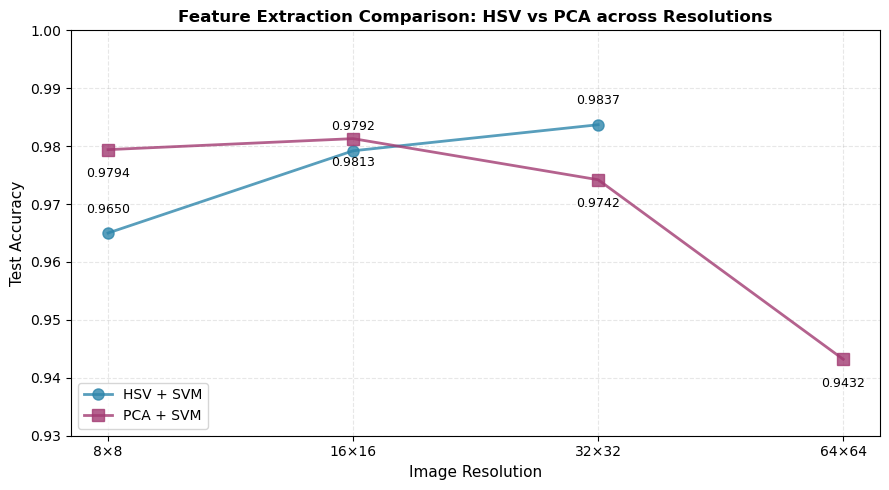


Summary Statistics:
Pipeline        8×8        16×16      32×32      64×64     
HSV + SVM       0.9650     0.9792     0.9837     —         
PCA + SVM       0.9794     0.9813     0.9742     0.9432    


In [ ]:
# Data from preliminary experiments
# HSV + SVM: tested at 8×8, 16×16, 32×32
hsv_resolutions = ['8×8', '16×16', '32×32']
hsv_svm_accuracy = [0.9650, 0.9792, 0.9837]

# PCA + SVM: tested at 8×8, 16×16, 32×32, 64×64
pca_resolutions = ['8×8', '16×16', '32×32', '64×64']
pca_svm_accuracy = [0.9794, 0.9813, 0.9742, 0.9432]

# Create comparison plot using line plot to handle different resolution sets
fig, ax = plt.subplots(figsize=(9, 5))

# Plot lines
ax.plot(range(len(hsv_resolutions)), hsv_svm_accuracy, 
        marker='o', markersize=8, linewidth=2, label='HSV + SVM', 
        color='#2E86AB', alpha=0.8)
ax.plot(range(len(pca_resolutions)), pca_svm_accuracy, 
        marker='s', markersize=8, linewidth=2, label='PCA + SVM', 
        color='#A23B72', alpha=0.8)

# Add value labels on points
for i, (res, acc) in enumerate(zip(hsv_resolutions, hsv_svm_accuracy)):
    ax.text(i, acc + 0.003, f'{acc:.4f}', ha='center', va='bottom', fontsize=9)

for i, (res, acc) in enumerate(zip(pca_resolutions, pca_svm_accuracy)):
    ax.text(i, acc - 0.003, f'{acc:.4f}', ha='center', va='top', fontsize=9)

ax.set_xlabel('Image Resolution', fontsize=11)
ax.set_ylabel('Test Accuracy', fontsize=11)
ax.set_title('Feature Extraction Comparison: HSV vs PCA across Resolutions', fontsize=12, fontweight='bold')
ax.set_xticks(range(len(pca_resolutions)))
ax.set_xticklabels(pca_resolutions)
ax.set_ylim([0.93, 1.0])
ax.legend(loc='lower left', fontsize=10)
ax.grid(axis='both', alpha=0.3, linestyle='--')

plt.tight_layout()
save_fig("fig_5.1_resolution_comparison_hsv_pca.png")
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("=" * 60)
print(f"{'Pipeline':<15} {'8×8':<10} {'16×16':<10} {'32×32':<10} {'64×64':<10}")
print("=" * 60)
print(f"{'HSV + SVM':<15} {hsv_svm_accuracy[0]:<10.4f} {hsv_svm_accuracy[1]:<10.4f} {hsv_svm_accuracy[2]:<10.4f} {'—':<10}")
print(f"{'PCA + SVM':<15} {pca_svm_accuracy[0]:<10.4f} {pca_svm_accuracy[1]:<10.4f} {pca_svm_accuracy[2]:<10.4f} {pca_svm_accuracy[3]:<10.4f}")
print("=" * 60)

## Section 5.2: Robustness Analysis

Evaluation of clean-trained models under various degradation conditions.

### 5.2.1 - Single Degradation Effects
### 5.2.2 - Combined Scenario Testing

Saved report_assets/figures/fig_5.2.1_single_degradations.png


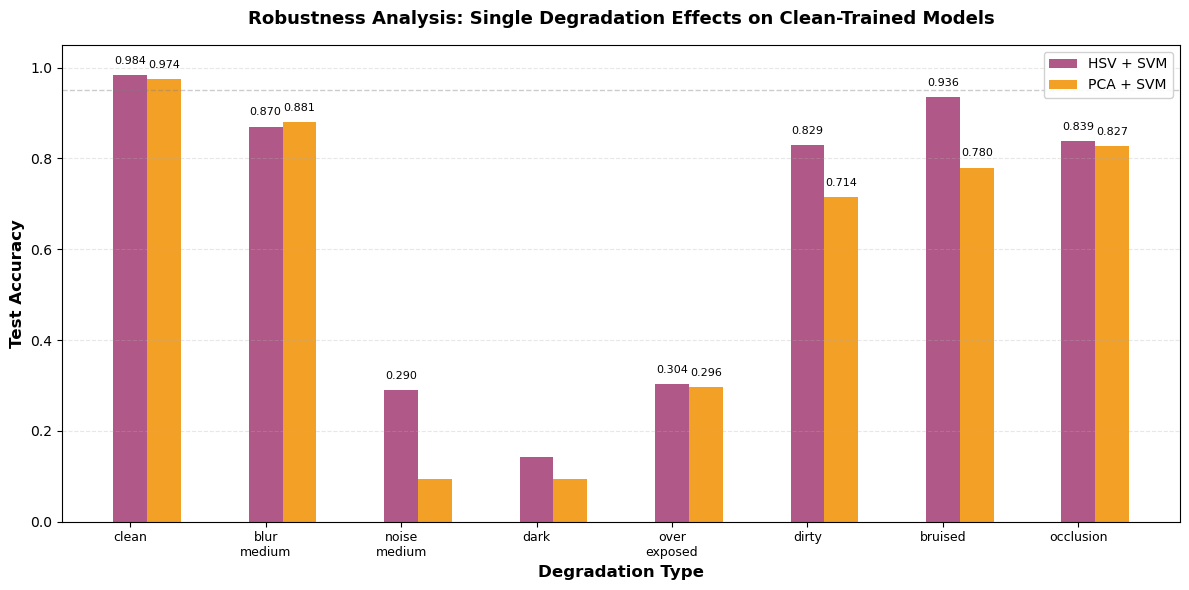


Single Degradation Effects - Summary:
Degradation          HSV+SVM      PCA+SVM     
clean                0.9837       0.9742      
blur_medium          0.8700       0.8810      
noise_medium         0.2900       0.0946      
dark                 0.1415       0.0941      
overexposed          0.3040       0.2960      
dirty                0.8293       0.7139      
bruised              0.9356       0.7798      
occlusion            0.8388       0.8273      

Average accuracy drop from clean baseline:
  HSV+k-NN: 0.3642
  HSV+SVM:  0.3824
  PCA+SVM:  0.4475


In [19]:
# Figure 1: Single Degradation Effects
# Data from robustness testing on clean-trained models

degradations = ['clean', 'blur\nmedium', 'noise\nmedium', 'dark', 'over\nexposed', 'dirty', 'bruised', 'occlusion']

# HSV pipeline results
hsv_svm = [0.9837, 0.870034, 0.290019, 0.141476, 0.304015, 0.829336, 0.935592, 0.838774]

# PCA pipeline results
pca_svm = [0.9742, 0.8810, 0.0946, 0.0941, 0.2960, 0.7139, 0.7798, 0.8273]

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(degradations))
width = 0.25

bars2 = ax.bar(x, hsv_svm, width, label='HSV + SVM', color='#A23B72', alpha=0.85)
bars3 = ax.bar(x + width, pca_svm, width, label='PCA + SVM', color='#F18F01', alpha=0.85)

# Add value labels on bars (only for bars > 0.15 to avoid clutter)
for bars in [bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0.15:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8, rotation=0)

ax.set_xlabel('Degradation Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Robustness Analysis: Single Degradation Effects on Clean-Trained Models', 
             fontsize=13, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(degradations, fontsize=9)
ax.set_ylim([0, 1.05])
ax.axhline(y=0.95, color='gray', linestyle='--', alpha=0.4, linewidth=1)
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
save_fig("fig_5.2.1_single_degradations.png")
plt.show()

# Print summary
print("\nSingle Degradation Effects - Summary:")
print("=" * 80)
print(f"{'Degradation':<20} {'HSV+SVM':<12} {'PCA+SVM':<12}")
print("=" * 80)
for i, deg in enumerate(['clean', 'blur_medium', 'noise_medium', 'dark', 'overexposed', 'dirty', 'bruised', 'occlusion']):
    print(f"{deg:<20} {hsv_svm[i]:<12.4f} {pca_svm[i]:<12.4f}")
print("=" * 80)

# Calculate average drop from clean
clean_hsv_knn, clean_hsv_svm, clean_pca_svm = hsv_knn[0], hsv_svm[0], pca_svm[0]
avg_drop_hsv_knn = np.mean([clean_hsv_knn - acc for acc in hsv_knn[1:]])
avg_drop_hsv_svm = np.mean([clean_hsv_svm - acc for acc in hsv_svm[1:]])
avg_drop_pca_svm = np.mean([clean_pca_svm - acc for acc in pca_svm[1:]])

print(f"\nAverage accuracy drop from clean baseline:")
print(f"  HSV+k-NN: {avg_drop_hsv_knn:.4f}")
print(f"  HSV+SVM:  {avg_drop_hsv_svm:.4f}")
print(f"  PCA+SVM:  {avg_drop_pca_svm:.4f}")

Saved report_assets/figures/fig_5.2.2_combined_scenarios.png


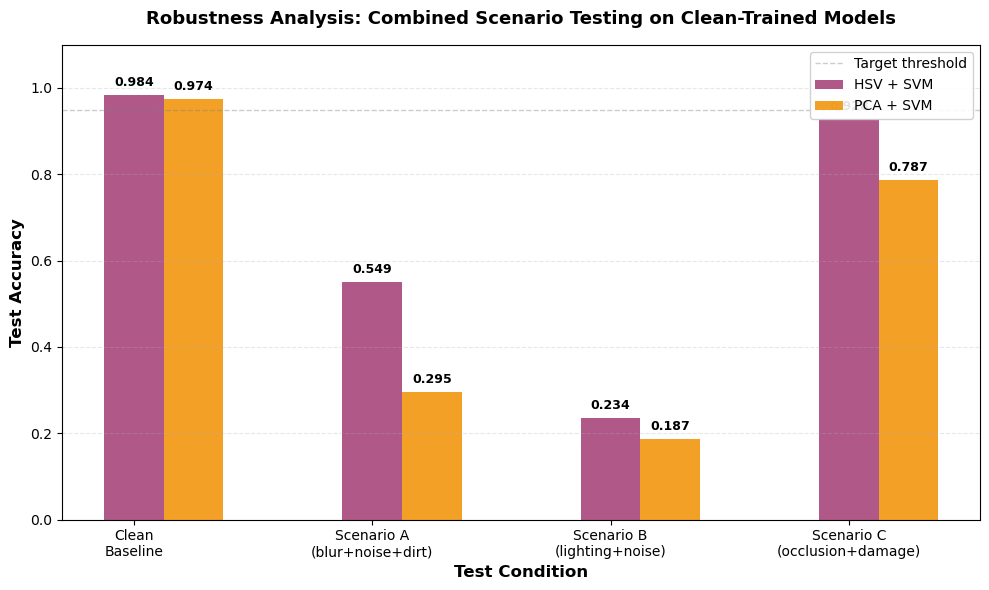


Combined Scenario Testing - Summary:
Scenario                       HSV+k-NN     HSV+SVM      PCA+SVM     
Clean Baseline                 0.9823       0.9837       0.9742      
Scenario A                     0.6375       0.5494       0.2953      
Scenario B                     0.2448       0.2343       0.1866      
Scenario C                     0.9473       0.9281       0.7866      

Performance Degradation from Clean Baseline:
Scenario A                     k-NN: -0.3448  SVM: -0.4343  PCA: -0.6789
Scenario B                     k-NN: -0.7376  SVM: -0.7494  PCA: -0.7876
Scenario C                     k-NN: -0.0351  SVM: -0.0556  PCA: -0.1876

Most Robust Method per Scenario:
  Scenario A: HSV+k-NN (0.6375)
  Scenario B: HSV+k-NN (0.2448)
  Scenario C: HSV+k-NN (0.9473)


In [21]:
# Figure 2: Combined Scenario Testing
# Composite degradation scenarios with multiple simultaneous effects

scenarios = ['Clean\nBaseline', 'Scenario A\n(blur+noise+dirt)', 'Scenario B\n(lighting+noise)', 'Scenario C\n(occlusion+damage)']

# Results for composite scenarios
hsv_svm_scenarios = [0.9837, 0.549353, 0.234289, 0.928065]
pca_svm_scenarios = [0.9742, 0.2953, 0.1866, 0.7866]

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(scenarios))
width = 0.25

bars2 = ax.bar(x, hsv_svm_scenarios, width, label='HSV + SVM', color='#A23B72', alpha=0.85)
bars3 = ax.bar(x + width, pca_svm_scenarios, width, label='PCA + SVM', color='#F18F01', alpha=0.85)

# Add value labels on bars
for bars in [bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.015,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Test Condition', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Robustness Analysis: Combined Scenario Testing on Clean-Trained Models', 
             fontsize=13, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(scenarios, fontsize=10)
ax.set_ylim([0, 1.1])
ax.axhline(y=0.95, color='gray', linestyle='--', alpha=0.4, linewidth=1, label='Target threshold')
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
save_fig("fig_5.2.2_combined_scenarios.png")
plt.show()

# Print summary
print("\nCombined Scenario Testing - Summary:")
print("=" * 80)
print(f"{'Scenario':<30} {'HSV+k-NN':<12} {'HSV+SVM':<12} {'PCA+SVM':<12}")
print("=" * 80)
for i, scen in enumerate(['Clean Baseline', 'Scenario A', 'Scenario B', 'Scenario C']):
    print(f"{scen:<30} {hsv_knn_scenarios[i]:<12.4f} {hsv_svm_scenarios[i]:<12.4f} {pca_svm_scenarios[i]:<12.4f}")
print("=" * 80)

# Calculate performance degradation
print("\nPerformance Degradation from Clean Baseline:")
print("=" * 80)
for i, scen in enumerate(['Scenario A', 'Scenario B', 'Scenario C']):
    drop_knn = hsv_knn_scenarios[0] - hsv_knn_scenarios[i+1]
    drop_svm = hsv_svm_scenarios[0] - hsv_svm_scenarios[i+1]
    drop_pca = pca_svm_scenarios[0] - pca_svm_scenarios[i+1]
    print(f"{scen:<30} k-NN: -{drop_knn:.4f}  SVM: -{drop_svm:.4f}  PCA: -{drop_pca:.4f}")
print("=" * 80)

# Identify most robust method per scenario
print("\nMost Robust Method per Scenario:")
for i, scen in enumerate(['Scenario A', 'Scenario B', 'Scenario C']):
    accs = [hsv_knn_scenarios[i+1], hsv_svm_scenarios[i+1], pca_svm_scenarios[i+1]]
    methods = ['HSV+k-NN', 'HSV+SVM', 'PCA+SVM']
    best_idx = np.argmax(accs)
    print(f"  {scen}: {methods[best_idx]} ({accs[best_idx]:.4f})")

Saved report_assets/figures/fig_5.2.3_mixed_realistic_distribution.png


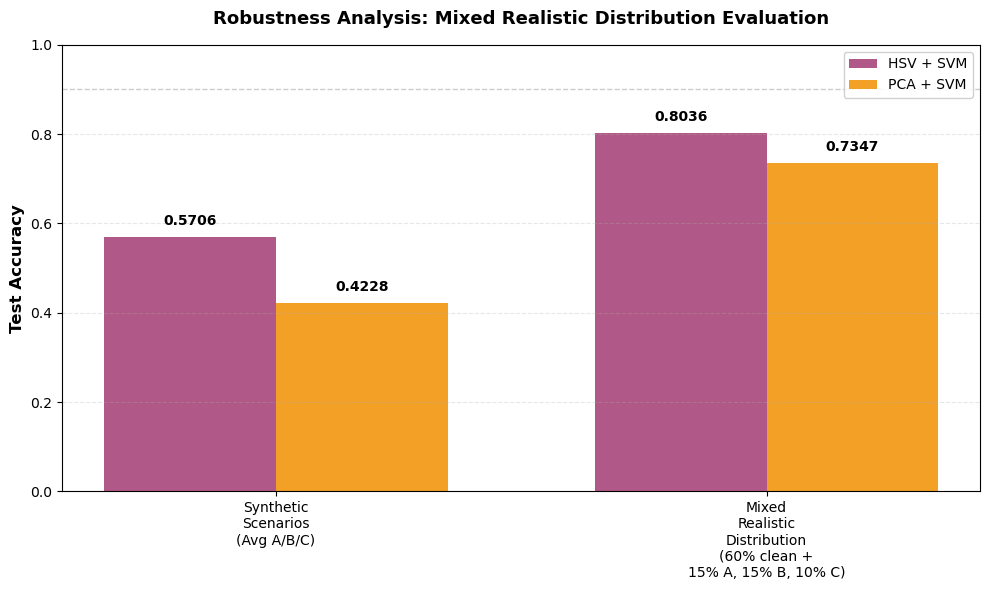


Mixed Realistic Distribution Evaluation:
Evaluation                          HSV+SVM         PCA+SVM        
Avg Synthetic Scenarios (A/B/C)     0.5706          0.4228         
Mixed Realistic (60% clean...)      0.8036          0.7347         

Improvement from Synthetic Average to Realistic Mixed:
  HSV+SVM: +0.2330 (+40.8% relative)
  PCA+SVM: +0.3119 (+73.8% relative)


In [22]:
# Figure 3: Mixed Realistic Distribution Evaluation
# Real-world deployment with heterogeneous conditions: 60% clean, 15% A, 15% B, 10% C

condition = ['Synthetic\nScenarios\n(Avg A/B/C)', 'Mixed\nRealistic\nDistribution\n(60% clean +\n15% A, 15% B, 10% C)']

# Results: Average of scenarios A/B/C vs mixed realistic distribution
hsv_synthetic_avg = np.mean([0.549353, 0.234289, 0.928065])
hsv_mixed = 0.8036

pca_synthetic_avg = np.mean([0.2953, 0.1866, 0.7866])
pca_mixed = 0.7347

# Create comparison chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(condition))
width = 0.35

bars1 = ax.bar(x - width/2, [hsv_synthetic_avg, hsv_mixed], width, 
               label='HSV + SVM', color='#A23B72', alpha=0.85)
bars2 = ax.bar(x + width/2, [pca_synthetic_avg, pca_mixed], width, 
               label='PCA + SVM', color='#F18F01', alpha=0.85)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Robustness Analysis: Mixed Realistic Distribution Evaluation', 
             fontsize=13, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(condition, fontsize=10)
ax.set_ylim([0, 1.0])
ax.axhline(y=0.9, color='gray', linestyle='--', alpha=0.4, linewidth=1)
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
save_fig("fig_5.2.3_mixed_realistic_distribution.png")
plt.show()

# Print summary
print("\nMixed Realistic Distribution Evaluation:")
print("=" * 80)
print(f"{'Evaluation':<35} {'HSV+SVM':<15} {'PCA+SVM':<15}")
print("=" * 80)
print(f"{'Avg Synthetic Scenarios (A/B/C)':<35} {hsv_synthetic_avg:<15.4f} {pca_synthetic_avg:<15.4f}")
print(f"{'Mixed Realistic (60% clean...)':<35} {hsv_mixed:<15.4f} {pca_mixed:<15.4f}")
print("=" * 80)

# Improvement analysis
print("\nImprovement from Synthetic Average to Realistic Mixed:")
hsv_improvement = hsv_mixed - hsv_synthetic_avg
pca_improvement = pca_mixed - pca_synthetic_avg
hsv_pct = (hsv_improvement / hsv_synthetic_avg * 100) if hsv_synthetic_avg > 0 else 0
pca_pct = (pca_improvement / pca_synthetic_avg * 100) if pca_synthetic_avg > 0 else 0

print(f"  HSV+SVM: +{hsv_improvement:.4f} ({hsv_pct:+.1f}% relative)")
print(f"  PCA+SVM: +{pca_improvement:.4f} ({pca_pct:+.1f}% relative)")
print("=" * 80)

## Section 5.3: Training Augmentation with Degraded Data

Impact of training augmentation percentage on test accuracy under degradation.
- HSV + SVM: augmentation 10%, 20%, 30%
- PCA + SVM: augmentation 10%, 20%, 30%

Saved report_assets/figures/fig_5.3_augmentation_impact.png


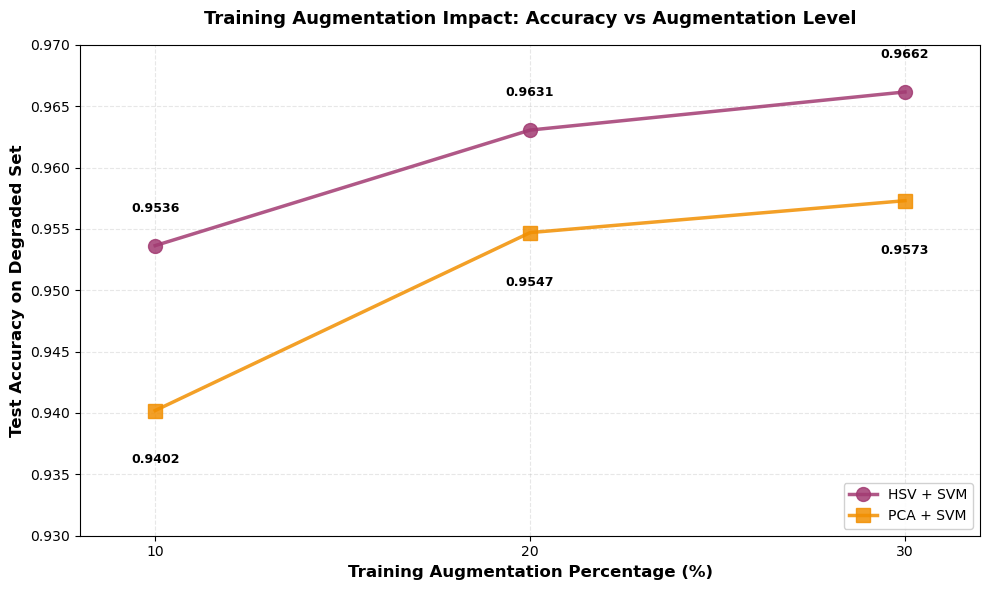


Training Augmentation Impact on Degraded Test Set:
Augmentation %       HSV+SVM              PCA+SVM             
10%                  0.9536               0.9402              
20%                  0.9631               0.9547              
30%                  0.9662               0.9573              

Improvement from 10% to 30% augmentation:
  HSV+SVM: +0.0125 (+1.31% relative)
  PCA+SVM: +0.0171 (+1.82% relative)


In [23]:
# Figure: Training Augmentation Impact on Robustness
# Test accuracy on degraded test set with varying augmentation percentages

augmentation_pct = [10, 20, 30]

# HSV + SVM test accuracy on degraded test set
hsv_svm_aug = [0.9536393352055614, 0.9630541871921182, 0.9661617789236223]

# PCA + SVM test accuracy on degraded test set
pca_svm_aug = [0.9402, 0.9547, 0.9573]

# Create line plot with markers
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(augmentation_pct, hsv_svm_aug, marker='o', markersize=10, linewidth=2.5, 
        label='HSV + SVM', color='#A23B72', alpha=0.85)
ax.plot(augmentation_pct, pca_svm_aug, marker='s', markersize=10, linewidth=2.5, 
        label='PCA + SVM', color='#F18F01', alpha=0.85)

# Add value labels on points
for i, (pct, acc) in enumerate(zip(augmentation_pct, hsv_svm_aug)):
    ax.text(pct, acc + 0.0025, f'{acc:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

for i, (pct, acc) in enumerate(zip(augmentation_pct, pca_svm_aug)):
    ax.text(pct, acc - 0.0035, f'{acc:.4f}', ha='center', va='top', fontsize=9, fontweight='bold')

ax.set_xlabel('Training Augmentation Percentage (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Accuracy on Degraded Set', fontsize=12, fontweight='bold')
ax.set_title('Training Augmentation Impact: Accuracy vs Augmentation Level', 
             fontsize=13, fontweight='bold', pad=15)
ax.set_xticks(augmentation_pct)
ax.set_xlim([8, 32])
ax.set_ylim([0.93, 0.97])
ax.legend(loc='lower right', fontsize=10, framealpha=0.9)
ax.grid(axis='both', alpha=0.3, linestyle='--')

plt.tight_layout()
save_fig("fig_5.3_augmentation_impact.png")
plt.show()

# Print summary
print("\nTraining Augmentation Impact on Degraded Test Set:")
print("=" * 70)
print(f"{'Augmentation %':<20} {'HSV+SVM':<20} {'PCA+SVM':<20}")
print("=" * 70)
for i, pct in enumerate(augmentation_pct):
    print(f"{pct}%{'':<17} {hsv_svm_aug[i]:<20.4f} {pca_svm_aug[i]:<20.4f}")
print("=" * 70)

# Calculate improvements
print("\nImprovement from 10% to 30% augmentation:")
hsv_improvement = hsv_svm_aug[2] - hsv_svm_aug[0]
pca_improvement = pca_svm_aug[2] - pca_svm_aug[0]
hsv_pct_improvement = (hsv_improvement / hsv_svm_aug[0]) * 100
pca_pct_improvement = (pca_improvement / pca_svm_aug[0]) * 100

print(f"  HSV+SVM: +{hsv_improvement:.4f} ({hsv_pct_improvement:+.2f}% relative)")
print(f"  PCA+SVM: +{pca_improvement:.4f} ({pca_pct_improvement:+.2f}% relative)")
print("=" * 70)

## Section 5.5: Exploratory Variants - Extended Feature Combinations

Comparison of test accuracy across different feature descriptor combinations on degraded test set.

Figure saved to: report_assets/figures/fig_5.5_extended_feature_combinations.png


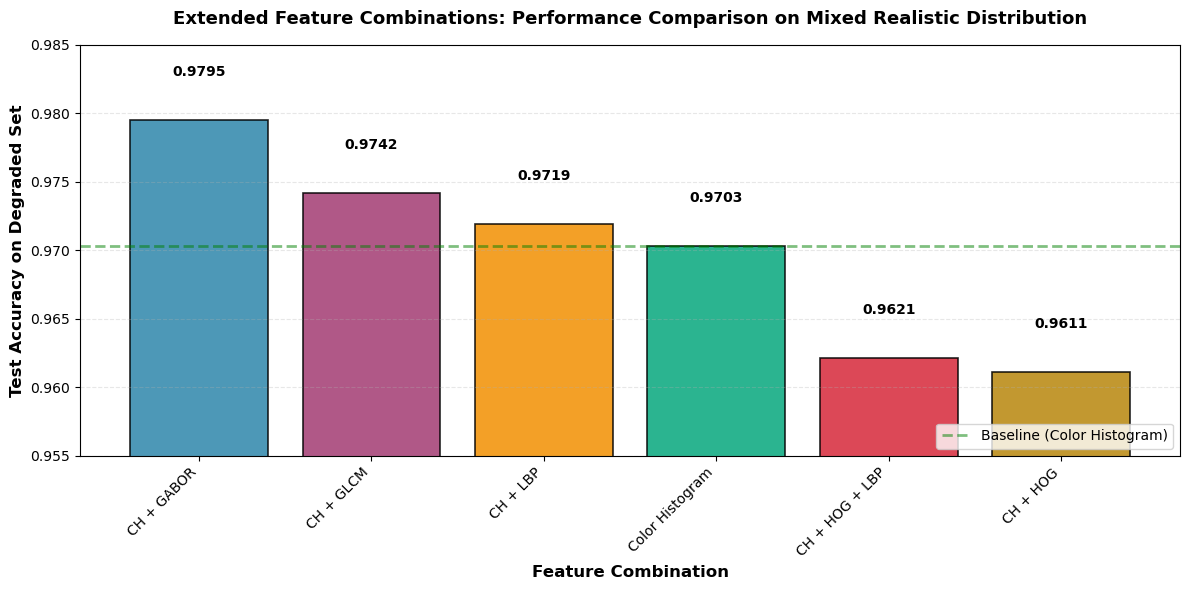


Extended Feature Combinations - Summary:
Feature Combination       Test Accuracy  
CH + GABOR                0.9795         
CH + GLCM                 0.9742         
CH + LBP                  0.9719         
Color Histogram           0.9703         
CH + HOG + LBP            0.9621         
CH + HOG                  0.9611         

Improvement over baseline (Color Histogram = 0.9703):
  CH + GABOR                +0.0092 (+0.95%)
  CH + GLCM                 +0.0039 (+0.40%)
  CH + LBP                  +0.0016 (+0.16%)
  CH + HOG + LBP            -0.0082 (-0.85%)
  CH + HOG                  -0.0092 (-0.95%)

Best performing: CH + GABOR (0.9795)
Baseline: Color Histogram (0.9703)


In [3]:
# Figure: Extended Feature Combinations Comparison
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

feature_combinations = [
    'CH + GABOR',
    'CH + GLCM',
    'CH + LBP',
    'Color Histogram',
    'CH + HOG + LBP',
    'CH + HOG',
]

test_accuracies = [0.9795, 0.9742, 0.9719, 0.9703, 0.9621, 0.9611]

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#2E86AB', '#A23B72', '#F18F01', '#06A77D', '#D62839', '#B8860B']
bars = ax.bar(range(len(feature_combinations)), test_accuracies, color=colors, alpha=0.85, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, test_accuracies)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.003,
            f'{acc:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Feature Combination', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Accuracy on Degraded Set', fontsize=12, fontweight='bold')
ax.set_title('Extended Feature Combinations: Performance Comparison on Mixed Realistic Distribution', 
             fontsize=13, fontweight='bold', pad=15)
ax.set_xticks(range(len(feature_combinations)))
ax.set_xticklabels(feature_combinations, rotation=45, ha='right', fontsize=10)
ax.set_ylim([0.955, 0.985])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add baseline reference line (Color Histogram baseline)
baseline_idx = 3
ax.axhline(y=test_accuracies[baseline_idx], color='green', linestyle='--', alpha=0.5, linewidth=2, label='Baseline (Color Histogram)')
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout()

# Save figure
FIG_DIR = Path("report_assets/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)
fig_path = FIG_DIR / "fig_5.5_extended_feature_combinations.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
print(f"Figure saved to: {fig_path}")
plt.show()

# Print summary
print("\nExtended Feature Combinations - Summary:")
print("=" * 70)
print(f"{'Feature Combination':<25} {'Test Accuracy':<15}")
print("=" * 70)
for combo, acc in sorted(zip(feature_combinations, test_accuracies), key=lambda x: x[1], reverse=True):
    print(f"{combo:<25} {acc:<15.4f}")
print("=" * 70)

# Calculate improvements over baseline
baseline_acc = test_accuracies[3]  # Color Histogram
print(f"\nImprovement over baseline (Color Histogram = {baseline_acc:.4f}):")
for combo, acc in zip(feature_combinations, test_accuracies):
    improvement = acc - baseline_acc
    improvement_pct = (improvement / baseline_acc) * 100
    if combo != 'Color Histogram':
        print(f"  {combo:<25} {improvement:+.4f} ({improvement_pct:+.2f}%)")

print(f"\nBest performing: {feature_combinations[test_accuracies.index(max(test_accuracies))]} ({max(test_accuracies):.4f})")
print(f"Baseline: Color Histogram ({baseline_acc:.4f})")